### **Classification of Observed Astronomical Objects**

Joseph P. Martin

Phase 2, Module 22: Final Capstone

Checkpoint 3: Submit Your Final Notebook

####**1. Introduction**

When the James Webb Space Telescope (JWST) was launched in December 2021, it renewed interest in capabilities for learning about remote objects in space. The JWST will make measurements in a section of the electromagnetic spectrum that extends from visible red light to non-visible infrared radiation. Compared to the Hubble Space Telescope, which makes measurements from the near-ultraviolet to near-infrared section of the band, the JWST’s enhanced infrared measurements will allow it to observe older and more distant objects and will also help us learn more about the atmosphere of exoplanets. It is an opportune time to reassess the optical properties associated with specific astronomical objects.

Here, we consider the relationship between observed optical properties and specific astronomical objects by investigating results from the Sloan Digital Sky Survey (SDSS), which uses an on-the-ground optical telescope in New Mexico. The question we are attempting to address is: Can we use optical properties from the SDSS to predict whether an astronomical object is a [star](https://en.wikipedia.org/wiki/Star), [galaxy](https://en.wikipedia.org/wiki/Galaxy), or [quasar](https://en.wikipedia.org/wiki/Quasar)?

This is thus primarily a supervised learning classification project. Logistic regression and decision tree are implemented and tuned so that we can try out both a linear and nonlinear model and maintain explanatory ability. Random forest is also used to improve upon decision tree. The project starts with exploratory data analysis to check the quality and distributions of data in the features and target class to prepare them for modeling. Feature selection methods such as filter methods and dimensionality reduction are considered. This is not an unsupervised learning project, because we know that there are 3 classes and what the class is for each observation, but we still use k-means clustering to see if it is informative. Deep Learning is also considered to see if it can improve upon the methods listed above. An artificial neural network (ANN) is built using TensorFlow and Keras.

####**2. Environment**

Import all needed libraies and methods:

In [ ]:
# set up environment

# installation of GPU version of TensorFlow 
!pip install tensorflow-gpu==2.0.0
# Keras comes bundles with TensorFlow

import datetime as dt
import graphviz # package for rendering decision tree
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydotplus # package for rendering decision tree
import seaborn as sn
import time
import warnings
warnings.filterwarnings("ignore")

from IPython.display import Image # a convenience for displaying visualizations
from scipy import stats
from sklearn import ensemble
from sklearn import metrics
from sklearn import tree
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential 
from tensorflow.keras.utils import to_categorical

In [ ]:
start_time_all = time.time()

Some of the methods below use a random state, so we set it here to keep it the same throughout:

In [ ]:
# set one random state to use throughout
rs = 777

####**3. Model Preparation: Dataset, Exploration, and Cleaning**

The data have been downloaded from [Kaggle](https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17) in the form of a 16 MB csv file with 100,000 rows and 18 columns. There is 1 row for each object observation, 17 feature columns, and 1 column indicating the known classification as a star, galaxy, or quasar. These data were originally extracted from the [Catalog Data](https://www.sdss.org/dr17/data_access/) set that summarizes quantities measured from images and spectra such as magnitudes, redshifts, and object classifications. The data can be extracted in a few different ways, including by [SQL query](http://skyserver.sdss.org/dr17/SearchTools/SQL/). The data are a combination of data stored in imaging and spectra tables. The 100,000 rows we are using here are a subset, because there are image and spectra data for approximately 0.5 × 10<sup>9</sup> and 3 × 10<sup>6</sup> objects, respectively. Here are descriptions of the features determined from review of the SDSS site:

| Column Name | Description |
| :-: | :-- |
| obj_ID | object identifier, the unique value that identifies the object in the image catalog |
| alpha | right ascension angle (at J2000 epoch, a measure of east-west position) |
| delta | declination angle (at J2000 epoch, a measure of north-south position) |
| u | magnitude measured in ultraviolet bandpass filter |
| g | magnitude measured in green bandpass filter |
| r | magnitude measured in red bandpass filter |
| i | magnitude measured in near infrared bandpass filter |
| z | magnitude measured in infrared bandpass filter |
| run_ID | the run number that identifies a specific scan; 1 of 3 numbers identifying image |
| rerun_ID | number that specifies how the image was processed |
| cam_col | the camera column that identifies scanline # among 6 parallel scanlines; 1 of 3 numbers identifying image |
| field_ID | the field number that identifies a patch of 10 × 13 arcminutes of sky; 1 of 3 numbers identifying image |
| spec_obj_ID | unique ID used for optical spectroscopic objects |
| class | object class (galaxy, star or quasar object) |
| redshift | redshift is an increase in the wavelength, and corresponding decrease in the frequency and photon energy, of electromagnetic radiation (fractional increase in wavelength) |
| plate | integer indicating which SDSS plug plate was used to collect the spectrum; 1 of 3 numbers identifying spectrum |
| MJD | integer for modified julian date of the night when the observation was carried out; 1 of 3 numbers identifying spectrum |
| fiber_ID | integer denoting the optical fiber number; 1 of 3 numbers identifying spectrum |

Read in the dataset.

In [ ]:
# Read in the dataset. 
# Storing the dataset on github avoids the authentication issue that occurs if 
# it is stored on Google Drive. It could not be read from Kaggle directly.
sc_orig_df = pd.read_csv('https://raw.githubusercontent.com/JosephMartin610/thinkful_data_science_flex_data_files/main/star_classification.csv')

Determine shape of the DataFrame.

In [ ]:
# Determine shape of the DataFrame.
print(sc_orig_df.shape)

(100000, 18)


There are 100,000 rows and 18 columns.

Let's obtain a concise summary of the DataFrame.

In [ ]:
# Obtain a concise summary of the DataFrame.
print(sc_orig_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

None of the columns have any missing data. They are all numerical except for class.

Let's look at the top rows of the data and the summary statistics.

In [ ]:
sc_orig_df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [ ]:
sc_orig_df.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237665e+18,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,4481.366060,301.0,3.511610,186.130520,5.783882e+18,0.576661,5137.009660,55588.647500,449.312740
std,8.438560e+12,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,1964.764593,0.0,1.586912,149.011073,3.324016e+18,0.730707,2952.303351,1808.484233,272.498404
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,3187.000000,301.0,2.000000,82.000000,2.844138e+18,0.054517,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,4188.000000,301.0,4.000000,146.000000,5.614883e+18,0.424173,4987.000000,55868.500000,433.000000
75%,1.237668e+18,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,5326.000000,301.0,5.000000,241.000000,8.332144e+18,0.704154,7400.250000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


Let's look at these columns further.

\#1. obj_ID:

- Let's see if there are any repeated IDs, that is, the same ID listed more than once.

In [ ]:
print(sc_orig_df['obj_ID'].size)
print(sc_orig_df['obj_ID'].unique().size)

100000
78053


- Because these numbers differ, some of the observed objects are in the dataset more than once. We can allow multiple observations of the same object to be used, as there does not appear to be anything disallowing this in the methods used below. There can be some variations between observations of an object that cause them to have a partial independence.
- Let's look at the histogram of obj_ID:

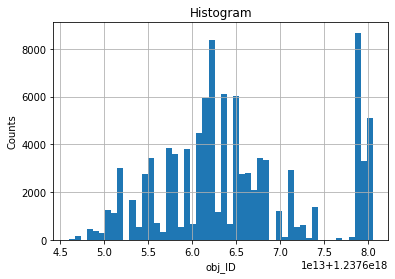

In [ ]:
# histogram
sc_orig_df['obj_ID'].hist(bins = 50)
plt.xlabel('obj_ID')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

- There are a range of obj_ID values in use and some have more members than others.

\#2. alpha:

- The range of possible values for right ascension, which is a measure of east-west position, is 0 to 360 degrees, and that is what we have here for alpha, so the alpha values are acceptable.
- Let's look at the histogram of alpha:

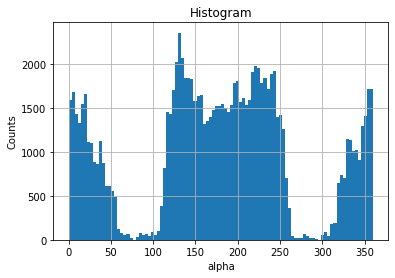

In [ ]:
# histogram
sc_orig_df['alpha'].hist(bins = 100)
plt.xlabel('alpha')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

- Some east-west poisitions are clearly observed more often than others. This likely has the sections of sky visible at night during various times of year.

\#3. delta:

- The theoretical range of possible values for decliniation, which is a measure of north-south position, is -90 to 90 degrees. We only have -18.7853 to 83.0005 degrees here, which averages to 32.1076. This is close to the latitude for Sunspot, New Mexico, where the telescope is located, 32.791 N, so this range of values appears acceptable.
- Let's look at the histogram of delta:

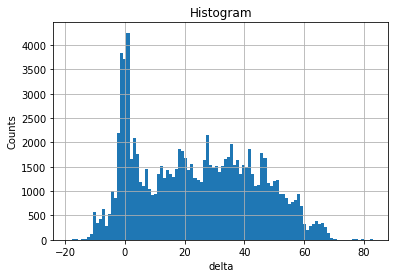

In [ ]:
# histogram
sc_orig_df['delta'].hist(bins = 100)
plt.xlabel('delta')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

- The north-south positions generally decline away from a center close to the telescope's latitude, but this trend is disrupted by a large peak at 0, which is the celestial equator.

\#4.–\#8. u, g, r, i, z

- These are values for the magnitudes of radiation passing through different filter bands. 
- Let's look at the histograms of the data in these columns:

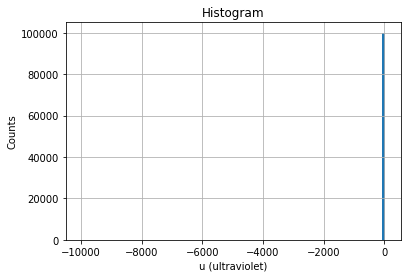

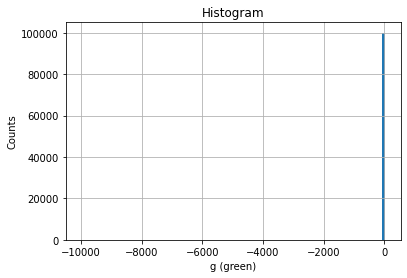

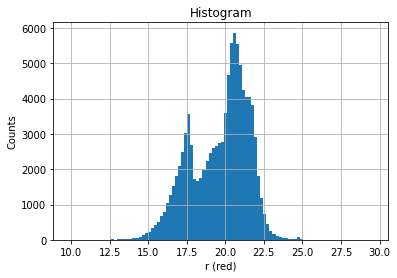

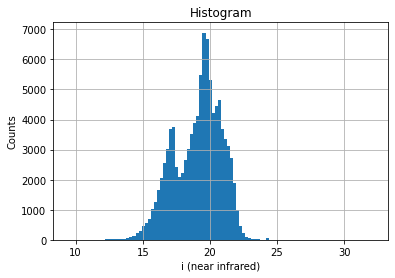

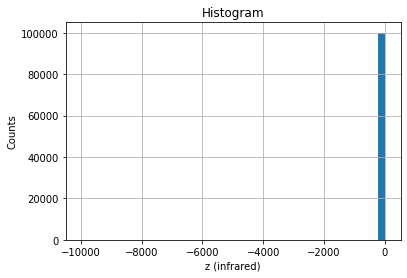

In [ ]:
# histograms

sc_orig_df['u'].hist(bins = 100)
plt.xlabel('u (ultraviolet)')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

sc_orig_df['g'].hist(bins = 100)
plt.xlabel('g (green)')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

sc_orig_df['r'].hist(bins = 100)
plt.xlabel('r (red)')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

sc_orig_df['i'].hist(bins = 100)
plt.xlabel('i (near infrared)')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

sc_orig_df['z'].hist(bins = 40)
plt.xlabel('z (infrared)')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

- There are -9999s present that are used for missing data in u, g,, r, i, and z, and these should be eliminated.

\#9. run_ID:

- The range of run_ID values appears to be acceptable. There could be an effect from variations in conditions among scans.
- Let's look at the histogram of run_ID:

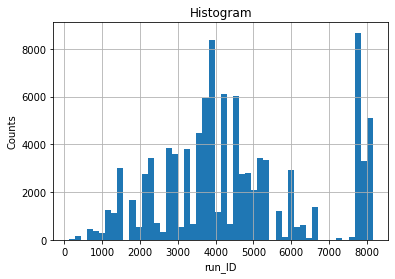

In [ ]:
# histogram
sc_orig_df['run_ID'].hist(bins = 50)
plt.xlabel('run_ID')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

- There are a range of run_ID values in use and some have more members than others.

\#10. rerun_ID:

- rerun_ID has a constant value of 301, so this column contributes nothing and should be removed. This has to do with multiple reprocessing of the data. Each reprocessing has been denoted by an integer: the first being rerun 0, the latest being rerun 301. Each rerun consists only in a change to the photometric pipeline, not to the underlying data.


\#11. cam_col:

- The range of cam_col values appears to be acceptable. There could be an effect from variations in conditions among the 6 scanlines.
- Let's look at the histogram of cam_col:

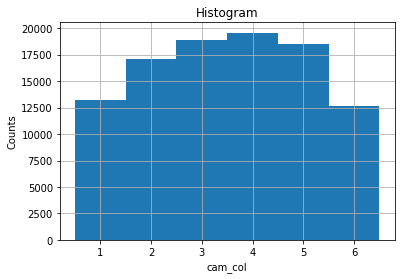

In [ ]:
# histogram
sc_orig_df['cam_col'].hist(bins = [0.5,1.5,2.5,3.5,4.5,5.5,6.5])
plt.xlabel('cam_col')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

- The camera columns toward the middle are used more than the outer ones.

\#12. field_ID:

- There is no compelling reason to think the values for field_ID are unacceptable. Some long runs can have a lot of fields.
- Let's look at the histogram of field_ID:

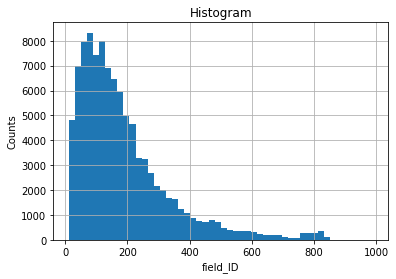

In [ ]:
# histogram
sc_orig_df['field_ID'].hist(bins = 50)
plt.xlabel('field_ID')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

- It appears the field_ID counter resets at each scan, and thus there is a most typical value at roughly 50.

\#13. spec_obj_ID:

In [ ]:
print(sc_orig_df['spec_obj_ID'].size)
print(sc_orig_df['spec_obj_ID'].unique().size)

100000
100000


- Each value of spec_obj_ID is unique. Because each row has a unique ID, this does not contribute any information.

\#14. class:

In [ ]:
print(sc_orig_df['class'].unique())

['GALAXY' 'QSO' 'STAR']


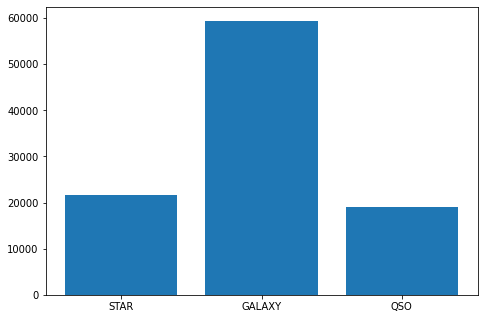

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
obj_classes = ['STAR', 'GALAXY', 'QSO']
obj_counts = sc_orig_df['class'].value_counts()[['STAR', 'GALAXY','QSO']]
ax.bar(obj_classes, obj_counts)
plt.show()

In [ ]:
print(sc_orig_df['class'].value_counts()[['STAR', 'GALAXY','QSO']])

STAR      21594
GALAXY    59445
QSO       18961
Name: class, dtype: int64


- Class is the target output. There are three values as expected: 'GALAXY', 'QSO' (for quasar), and 'STAR'. Interestingly, there are nearly three times more complete galaxies than individual stars. The number of quasars is the smallest among the three, but not much lower than the number of stars.  

\#15. redshift:

- In physics, a redshift is an increase in the wavelength, and corresponding decrease in the frequency and photon energy, of electromagnetic radiation (such as light). It is the fractional increase in wavelength. The opposite change, a decrease in wavelength and simultaneous increase in frequency and energy, is known as a negative redshift, or blueshift. Because of the [properties of space](https://en.wikipedia.org/wiki/Redshift), redshift should be more typical than blueshift and that is what we see here with most values positive. The values appear to be acceptable. Redshift could be important in classifying the objects because stars are much closer than galaxies and quasars and thus the impact of the properties of space is different for these objects.
- How many positive (red), zero, and negative (blue) values are there?:

In [ ]:
print('The number of positive redshift values is: {}.'.format(sc_orig_df[sc_orig_df['redshift'] > 0].shape[0]))
print('The number of zero redshift values is: {}.'.format(sc_orig_df[sc_orig_df['redshift'] == 0].shape[0]))
print('The number of negative redshift values is: {}.'.format(sc_orig_df[sc_orig_df['redshift'] < 0].shape[0]))

The number of positive redshift values is: 85864.
The number of zero redshift values is: 412.
The number of negative redshift values is: 13724.


- Let's look at the histograms of redshift for positive and negative values:

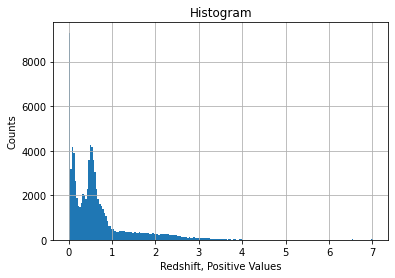

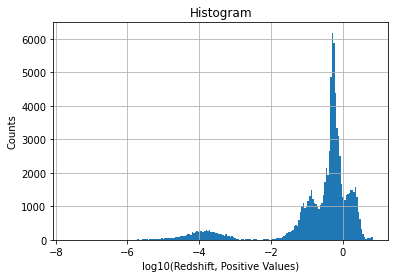

The maximum occurs at -0.30025553799466653.


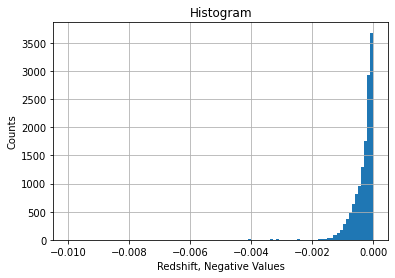

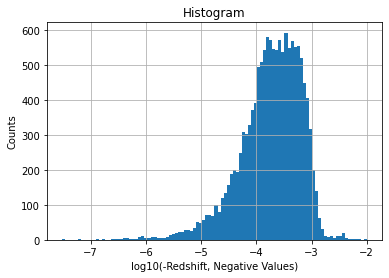

The maximum occurs at -3.490016033725471.


In [ ]:
# histograms

counts_rs_pos, bins_rs_pos, bars_rs_pos = plt.hist(sc_orig_df[sc_orig_df['redshift'] > 0]['redshift'], bins = 200)
plt.xlabel('Redshift, Positive Values')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

counts_rs_pos_log10, bins_rs_pos_log10, bars_rs_pos_log10 = plt.hist(np.log10(sc_orig_df[sc_orig_df['redshift'] > 0]['redshift']), bins=200)
plt.xlabel('log10(Redshift, Positive Values)')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()
print('The maximum occurs at {}.'.format(bins_rs_pos_log10[np.argmax(counts_rs_pos_log10)]))

counts_rs_neg, bins_rs_neg, bars_rs_neg = plt.hist(sc_orig_df[sc_orig_df['redshift'] < 0]['redshift'], bins = 100)
plt.xlabel('Redshift, Negative Values')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

counts_rs_neg_log10, bins_rs_neg_log10, bars_rs_neg_log10 = plt.hist(np.log10(-sc_orig_df[sc_orig_df['redshift'] < 0]['redshift']), bins=100)
plt.xlabel('log10(-Redshift, Negative Values)')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()
print('The maximum occurs at {}.'.format(bins_rs_neg_log10[np.argmax(counts_rs_neg_log10)]))

- There is quite a lot of interesting structure in redshift. In the positive (red) values, there is a long tail extending toward more positive values. The structure between 0 and 1 is easier to see on the log10 scaled histogram. The maximum occurs at -0.3003, so a redshift of 10<sup>-0.3003</sup> = 0.5008. There are smaller side peaks on either side of the main peak and then another bump out at redshifts near 10<sup>-4</sup>. The negative (blue) values are piled toward zero, but also have a tail extending toward more negative values. The structure between -0.002 and 0 is easier to see on the log10 scaled histogram. The maximum occurs at -3.4900, so so a redshift of -10<sup>-3.4900</sup> = -3.2359 x 10<sup>-4</sup>.

\#16. plate:

- The range of plate ID values appears to be acceptable. There could be an effect from variations in conditions among plates.
- Let's look at the histogram of plate:

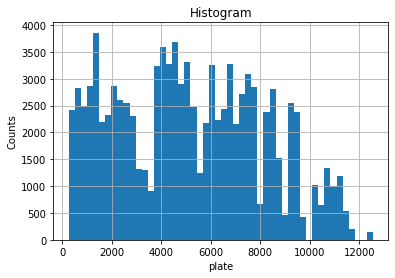

In [ ]:
# histogram
sc_orig_df['plate'].hist(bins = 50)
plt.xlabel('plate')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

- Some SDSS plug plates are used more than others, but there is some uniformity here.

\#17. MJD :

- Let's look at the range of dates in the data:

In [ ]:
mjd_base_date = dt.date(1858,11,17)
print('The earliest date in the data is {}.'.format(mjd_base_date + dt.timedelta(days=sc_orig_df['MJD'].min())))
print('The latest date in the data is {}.'.format(mjd_base_date + dt.timedelta(days=sc_orig_df['MJD'].max())))
print('The observations were made over {} years.'.format((sc_orig_df['MJD'].max() - sc_orig_df['MJD'].min()) / 365.25))

The earliest date in the data is 2000-03-05.
The latest date in the data is 2020-03-24.
The observations were made over 20.05201916495551 years.


- The observations were made over a period of 20 years from March 2000 to March 2020, so this could cause some variation in the observations.
- Let's look at the historgram of MJD:

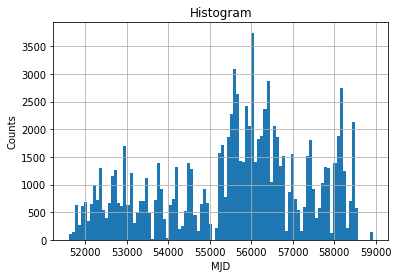

In [ ]:
# histogram
sc_orig_df['MJD'].hist(bins = 100)
plt.xlabel('MJD')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

- There were some years and times of year (variation in length of night or cloud cover) with more observations.

\#18. fiber_ID:

In [ ]:
sc_orig_df['fiber_ID'].unique().size

1000

- There are 1,000 fibers that are used. This could cause some variation in the observations.
- Let's look at histogram of fiber_ID:

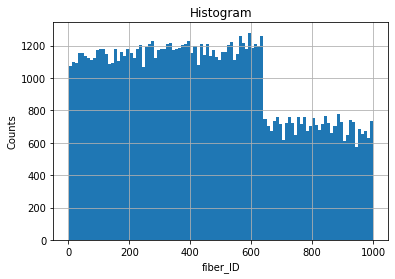

In [ ]:
# histogram
sc_orig_df['fiber_ID'].hist(bins = 100)
plt.xlabel('fiber_ID')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

- The distribution of fiber_IDs is uniform but ones below approximately 625 were in more frequent use.

Let's clean the data based on the above information:

In [ ]:
# copy the DataFrame
sc_df = sc_orig_df.copy()

In [ ]:
# exclude rows with u, g, or z == -9999
sc_df = sc_df.loc[sc_df['u'] != -9999]
sc_df = sc_df.loc[sc_df['g'] != -9999]
sc_df = sc_df.loc[sc_df['z'] != -9999]

In [ ]:
# remove columns that are not needed
sc_df = sc_df.drop(columns=['rerun_ID', 'spec_obj_ID'])

Let's check the columns and descriptive statistics again after the cleaning: 

In [ ]:
sc_df.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,cam_col,field_ID,redshift,plate,MJD,fiber_ID
count,9.999900e+04,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,1.237665e+18,177.628653,24.135552,22.080679,20.631583,19.645777,19.084865,18.768988,4481.403354,3.511625,186.127011,0.576667,5137.027890,55588.653687,449.315613
std,8.438450e+12,96.502612,19.644608,2.251068,2.037384,1.854763,1.757900,1.765982,1964.739021,1.586913,149.007687,0.730709,2952.312485,1808.492217,272.498252
min,1.237646e+18,0.005528,-18.785328,10.996230,10.498200,9.822070,9.469903,9.612333,109.000000,1.000000,11.000000,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.517698,5.147477,20.352410,18.965240,18.135795,17.732280,17.460830,3187.000000,2.000000,82.000000,0.054522,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900527,23.646462,22.179140,21.099930,20.125310,19.405150,19.004600,4188.000000,4.000000,146.000000,0.424176,4987.000000,55869.000000,433.000000
75%,1.237668e+18,233.895005,39.901582,23.687480,22.123775,21.044790,20.396510,19.921120,5326.000000,5.000000,241.000000,0.704172,7400.500000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,6.000000,989.000000,7.011245,12547.000000,58932.000000,1000.000000


Only one row had to be eliminated to address the -9999s. Everything else looks acceptable.

\#4.–\#8. u, g, r, i, z (second look)

- Let's take another look at the histograms for the magnitudes now that the -9999s have been removed:

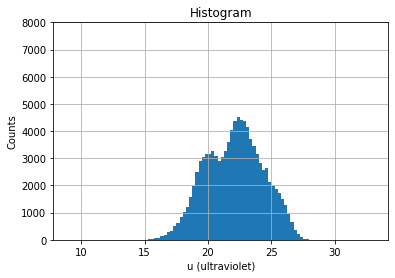

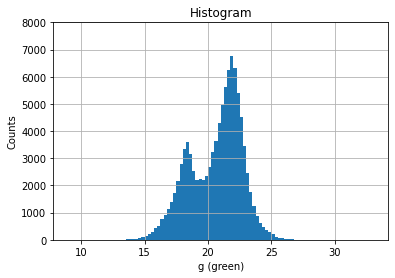

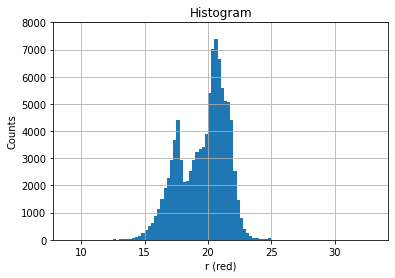

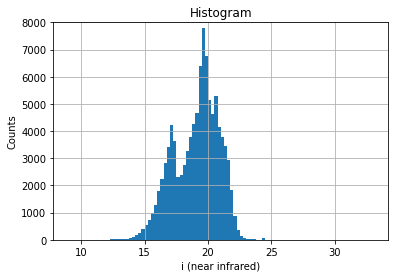

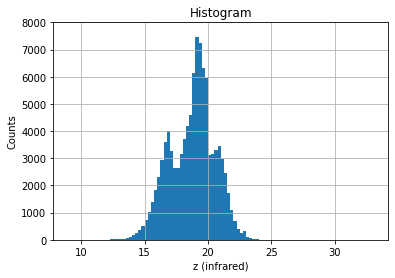

In [ ]:
hists_magnitude_start = 9
hists_magnitude_end = 33
hists_magnitude_step = 0.25
hists_magnitude_range = np.array([hists_magnitude_start, hists_magnitude_end])
hists_magnitude_bins = np.arange(hists_magnitude_start, hists_magnitude_end+hists_magnitude_step, hists_magnitude_step)

sc_orig_df['u'].hist(bins = hists_magnitude_bins, range = hists_magnitude_range)
plt.ylim(0,8000)
plt.xlabel('u (ultraviolet)')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

sc_orig_df['g'].hist(bins = hists_magnitude_bins, range = hists_magnitude_range)
plt.ylim(0,8000)
plt.xlabel('g (green)')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

sc_orig_df['r'].hist(bins = hists_magnitude_bins, range = hists_magnitude_range)
plt.ylim(0,8000)
plt.xlabel('r (red)')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

sc_orig_df['i'].hist(bins = hists_magnitude_bins, range = hists_magnitude_range)
plt.ylim(0,8000)
plt.xlabel('i (near infrared)')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

sc_orig_df['z'].hist(bins = hists_magnitude_bins, range = hists_magnitude_range)
plt.ylim(0,8000)
plt.xlabel('z (infrared)')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

- There is some interesting structure in the histograms of the magnitudes. There are at least 2 peaks in all of the filters. The peakiness generally increases with wavelength. The location of the main peak shifts to lower magnitudes with wavelength. There are tails in both directions in all of the filters.

####**4. Model Preparation: Class Imbalance, Descriptive Statistics and Need for Transformations, Normalization, and Unsupervised Learning**

Now that the data have been read in, explored, and cleaned, we take further steps in preparation for modeling.

#####**Class Imbalance**

- There is an imbalance in the classifications:

In [ ]:
sc_df['class'].value_counts()[['STAR', 'GALAXY','QSO']]

STAR      21593
GALAXY    59445
QSO       18961
Name: class, dtype: int64

- There are roughly three times as many galaxy observations as star or quasar observations.
- With such an imbalance, we risk having our model(s) achieve accuracy by predicting the majority galaxy class.
- In order to remove this imbalance, we undersample the majority galaxy class, and also undersample the star class, to match the number of observations in the quasar class. There are 18,961 quasar observations, so the tradeoff is that information from 59,445 - 18,961 = 40,484 galaxy observations are excluded from the model(s). Only 21,593 - 18,961 = 2,632 star observartions are excluded.
- Having a better permorming model is more important than including all of the galaxy observations.
- A random subsampling is used and the DataFrame reformed:  

In [ ]:
n_qso = sc_df['class'].value_counts()['QSO']
sc_sub_df = pd.concat( [sc_df[sc_df['class'] == 'STAR'].sample(n_qso, replace=False, random_state=rs, axis=0), \
                       sc_df[sc_df['class'] == 'GALAXY'].sample(n_qso, replace=False, random_state=rs, axis=0), \
                       sc_df[sc_df['class'] == 'QSO']], \
                       ignore_index=True)

- The classifications are now balanced:

In [ ]:
sc_sub_df['class'].value_counts()[['STAR', 'GALAXY','QSO']]

STAR      18961
GALAXY    18961
QSO       18961
Name: class, dtype: int64

#####**Descriptive Statistics and Possible Need for Transformations**

- Let's look at the descriptive statistics for each feature and whether the distributions are normal or not.
- We consider applying logarithmic transformations to any features that are unbound and have a highly skewed distribution.

In [ ]:
print('obj_ID:')
print(stats.describe(sc_sub_df['obj_ID']))
print(stats.normaltest(sc_sub_df['obj_ID']))

obj_ID:
DescribeResult(nobs=56883, minmax=(1.23764594290439e+18, 1.2376805313563863e+18), mean=1.2376646723436554e+18, variance=7.180205361142027e+25, skewness=0.4058862863755792, kurtosis=-0.6265944671924366)
NormaltestResult(statistic=3552.3609226739227, pvalue=0.0)


In [ ]:
print('alpha:')
print(stats.describe(sc_sub_df['alpha']))
print(stats.normaltest(sc_sub_df['alpha']))

alpha:
DescribeResult(nobs=56883, minmax=(0.0109586937406903, 359.99961524169), mean=177.3864559929521, variance=9582.211935327809, skewness=-0.017608209814417578, kurtosis=-0.6093351347777212)
NormaltestResult(statistic=1933.9603916508318, pvalue=0.0)


In [ ]:
print('delta:')
print(stats.describe(sc_sub_df['delta']))
print(stats.normaltest(sc_sub_df['delta']))

delta:
DescribeResult(nobs=56883, minmax=(-18.7853280771825, 83.00051858898), mean=24.545418149728537, variance=392.3481564105178, skewness=0.12004779977329087, kurtosis=-1.0931601962482762)
NormaltestResult(statistic=22613.498091782865, pvalue=0.0)


In [ ]:
print('u:')
print(stats.describe(sc_sub_df['u']))
print(stats.normaltest(sc_sub_df['u']))

u:
DescribeResult(nobs=56883, minmax=(10.99623, 32.78139), mean=21.761836435138793, variance=4.686424268326439, skewness=0.045816110679496154, kurtosis=-0.35286616307640717)
NormaltestResult(statistic=460.84232499241205, pvalue=8.498858804532996e-101)


In [ ]:
print('g:')
print(stats.describe(sc_sub_df['g']))
print(stats.normaltest(sc_sub_df['g']))

g:
DescribeResult(nobs=56883, minmax=(10.4982, 30.607), mean=20.480916789550484, variance=3.806410367339635, skewness=-0.4125153973410968, kurtosis=-0.14915916446040223)
NormaltestResult(statistic=1554.0251221201927, pvalue=0.0)


In [ ]:
print('r:')
print(stats.describe(sc_sub_df['r']))
print(stats.normaltest(sc_sub_df['r']))

r:
DescribeResult(nobs=56883, minmax=(9.82207, 29.37411), mean=19.71694293936677, variance=3.334948626783354, skewness=-0.5967039699813833, kurtosis=-0.17842679237392156)
NormaltestResult(statistic=2994.8877742003497, pvalue=0.0)


In [ ]:
print('i:')
print(stats.describe(sc_sub_df['i']))
print(stats.normaltest(sc_sub_df['i']))

i:
DescribeResult(nobs=56883, minmax=(9.469903, 32.14147), mean=19.27311738345375, variance=3.1508664341484836, skewness=-0.5184841013612796, kurtosis=-0.117270364120591)
NormaltestResult(statistic=2302.161767118456, pvalue=0.0)


In [ ]:
print('z:')
print(stats.describe(sc_sub_df['z']))
print(stats.normaltest(sc_sub_df['z']))

z:
DescribeResult(nobs=56883, minmax=(9.612333, 29.38374), mean=19.015105230965315, variance=3.229148120921156, skewness=-0.40137352933007486, kurtosis=-0.2388329303828325)
NormaltestResult(statistic=1593.4771674296492, pvalue=0.0)


In [ ]:
print('run_ID:')
print(stats.describe(sc_sub_df['run_ID']))
print(stats.normaltest(sc_sub_df['run_ID']))

run_ID:
DescribeResult(nobs=56883, minmax=(109, 8162), mean=4469.845577764886, variance=3892427.846903328, skewness=0.40588109309982523, kurtosis=-0.6265911302494191)
NormaltestResult(statistic=3552.2917221574403, pvalue=0.0)


In [ ]:
print('cam_col:')
print(stats.describe(sc_sub_df['cam_col']))
print(stats.normaltest(sc_sub_df['cam_col']))

cam_col:
DescribeResult(nobs=56883, minmax=(1, 6), mean=3.52841798076754, variance=2.5301292558997446, skewness=-0.023950765920880145, kurtosis=-1.11777368759486)
NormaltestResult(statistic=26426.764113772224, pvalue=0.0)


In [ ]:
print('field_ID:')
print(stats.describe(sc_sub_df['field_ID']))
print(stats.normaltest(sc_sub_df['field_ID']))

field_ID:
DescribeResult(nobs=56883, minmax=(11, 989), mean=183.428159555579, variance=21209.864617524418, skewness=1.7693437598503294, kurtosis=3.8997276426923912)
NormaltestResult(statistic=19617.93328875507, pvalue=0.0)


In [ ]:
print('redshift:')
print(stats.describe(sc_sub_df['redshift']))
print(stats.normaltest(sc_sub_df['redshift']))

redshift:
DescribeResult(nobs=56883, minmax=(-0.009970667, 7.011245), mean=0.7133698983441004, variance=0.8376107179285291, skewness=1.8444482345269273, kurtosis=5.001041363109755)
NormaltestResult(statistic=21498.294447605458, pvalue=0.0)


In [ ]:
print('plate:')
print(stats.describe(sc_sub_df['plate']))
print(stats.normaltest(sc_sub_df['plate']))

plate:
DescribeResult(nobs=56883, minmax=(266, 12547), mean=5360.092839688484, variance=9030785.50583161, skewness=0.15736709226161422, kurtosis=-0.9859044209047316)
NormaltestResult(statistic=12348.786932663983, pvalue=0.0)


In [ ]:
print('MJD:')
print(stats.describe(sc_sub_df['MJD']))
print(stats.normaltest(sc_sub_df['MJD']))

MJD:
DescribeResult(nobs=56883, minmax=(51608, 58932), mean=55724.539264806706, variance=3257190.5797097865, skewness=-0.39840938524359815, kurtosis=-0.7629121534840038)
NormaltestResult(statistic=5453.901245413284, pvalue=0.0)


In [ ]:
print('fiber_ID:')
print(stats.describe(sc_sub_df['fiber_ID']))
print(stats.normaltest(sc_sub_df['fiber_ID']))

fiber_ID:
DescribeResult(nobs=56883, minmax=(1, 1000), mean=450.2129107114604, variance=74575.0818965292, skewness=0.2232448372062036, kurtosis=-0.986178790536981)
NormaltestResult(statistic=12595.746557775105, pvalue=0.0)


- None of the features have a skewness outside of -3 or +3, so we do not apply a logaritmic transformation to any of the features.
- All of the p-values of the normaltest (D’Agostino and Pearson’s test) are well less than 0.05, so none of the features can be considered normally distributed. This is as expected from what we see in the histograms above. 

#####**Extraction and Normalization**

- Extract the features (X_orig) and target outcome (y):

In [ ]:
X_orig = sc_sub_df.drop(columns='class')
y = sc_sub_df['class']

- Normalize the features so that they all have a mean of 0 and a standard deviation of 1. This will eliminate any impacts from differences in ranges and variances among the features.

In [ ]:
# normalize the data so that all variables have a mean of 0 and standard deviation of 1.
X = pd.DataFrame(StandardScaler().fit_transform(X_orig), columns = X_orig.columns)

- Let's confirm the normalization:

In [ ]:
X.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,cam_col,field_ID,redshift,plate,MJD,fiber_ID
count,5.688300e+04,5.688300e+04,5.688300e+04,5.688300e+04,5.688300e+04,5.688300e+04,5.688300e+04,5.688300e+04,5.688300e+04,5.688300e+04,5.688300e+04,5.688300e+04,5.688300e+04,5.688300e+04,5.688300e+04
mean,1.949682e-11,5.141000e-16,-1.415548e-16,-3.238370e-16,-3.419900e-15,1.304964e-16,1.061080e-15,-6.846785e-16,1.055277e-15,4.915025e-16,-1.258030e-16,-5.212425e-16,-4.778411e-16,1.371030e-15,-3.114706e-16
std,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00
min,-2.210345e+00,-1.812027e+00,-2.187581e+00,-4.973035e+00,-5.116757e+00,-5.418380e+00,-5.522775e+00,-5.232578e+00,-2.210366e+00,-1.589576e+00,-1.183976e+00,-7.903610e-01,-1.695149e+00,-2.280943e+00,-1.644975e+00
25%,-6.538163e-01,-5.365147e-01,-9.788857e-01,-7.192670e-01,-7.326154e-01,-7.134107e-01,-6.842656e-01,-6.809252e-01,-6.537794e-01,-9.608921e-01,-6.964556e-01,-7.793899e-01,-8.811995e-01,-6.740752e-01,-8.356938e-01
50%,-1.612034e-01,3.655644e-02,1.442541e-02,-6.959748e-03,1.964101e-01,2.504354e-01,1.831116e-01,1.305671e-01,-1.611053e-01,2.964761e-01,-2.638666e-01,-3.217666e-01,-6.458781e-02,1.404407e-01,-5.937012e-02
75%,5.717912e-01,5.959264e-01,8.233997e-01,6.753424e-01,7.072571e-01,7.566839e-01,7.733927e-01,7.526318e-01,5.718236e-01,9.251602e-01,3.747171e-01,4.496786e-01,7.776470e-01,7.599160e-01,7.206154e-01
max,1.871594e+00,1.865533e+00,2.951144e+00,5.090343e+00,5.190241e+00,5.288214e+00,7.249562e+00,5.770074e+00,1.871429e+00,1.553844e+00,5.531452e+00,6.881399e+00,2.391570e+00,1.777230e+00,2.013268e+00


- The normalization is correct to within expected error levels.

#####**Unsupervised Learning Considerations**

- Even though this is a supervised learning project, we can consider unsupervised learning methods to determine if they provide any useful information about the features or for modeling.

- We can use principal component analysis (PCA) to consider if a significant information in the features can be consolidated into a reduced number of components:

In [ ]:
pca = PCA()
pca_components = pca.fit_transform(X)

d_pca_table = {'Component #': np.arange(1, pca.explained_variance_ratio_.size+1), \
               '% Variance': pca.explained_variance_ratio_*100, \
               'Sum % Variance': pca.explained_variance_ratio_.cumsum()*100}

pca_table = pd.DataFrame(data=d_pca_table)

print('The percentage of total variance in each component and the cumulative variance explained are:')
pca_table

The percentage of total variance in each component and the cumulative variance explained are:


,Component #,% Variance,Sum % Variance
0,1,3.707234e+01,37.072343
1,2,1.401259e+01,51.084932
2,3,9.369010e+00,60.453942
3,4,7.345134e+00,67.799075
4,5,7.152988e+00,74.952064
5,6,5.785831e+00,80.737894
6,7,5.747349e+00,86.485243
7,8,5.308940e+00,91.794183
8,9,4.329722e+00,96.123905
9,10,2.824839e+00,98.948744


- The first 2 components explain more than 50% of the variance and the first 8 more than 90%, so there is an ability to include much of the information from all of the features in a smaller number of principal components.

- We can visualize our dataset in two-dimensional space using the first two components of the PCA.

- A color can be chosen for each class and then assigned to each observation. We will use blue for stars, green for galaxies, and red for quasars:

In [ ]:
colors_class = np.empty(y.shape[0], dtype=str)
colors_class[y == 'STAR'] = 'b'
colors_class[y == 'GALAXY'] = 'g'
colors_class[y == 'QSO'] = 'r'

- First, determine the range of values in the components:

In [ ]:
print([min(pca_components[:,0]), max(pca_components[:,0])])
print([min(pca_components[:,1]), max(pca_components[:,1])])

[-7.7820409491517415, 9.982430087636075]
[-3.383674090084785, 3.961315103350198]


We plot the positions of the data in the two components and use the class colors, with each one taking a turn on top.

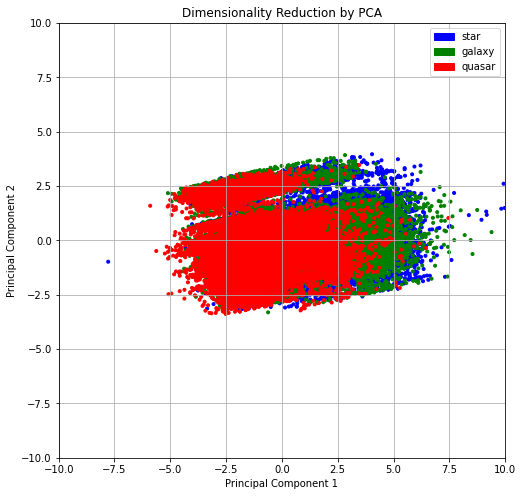

In [ ]:
fig_pca, ax_pca = plt.subplots(figsize=(8,8))
ax_pca.scatter(pca_components[:,0], pca_components[:,1], c=colors_class,  marker='.')
ax_pca.set_xlim(-10,10)
ax_pca.set_ylim(-10,10)
blue_patch = mpatches.Patch(color='blue', label='star')
green_patch = mpatches.Patch(color='green', label='galaxy')
red_patch = mpatches.Patch(color='red', label='quasar')
ax_pca.legend(handles=[blue_patch, green_patch, red_patch])
plt.grid()
plt.title("Dimensionality Reduction by PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

Using the first two PCA components, there is a lot of overlap among the classes, and they cover each other up, so let's look at them individually:

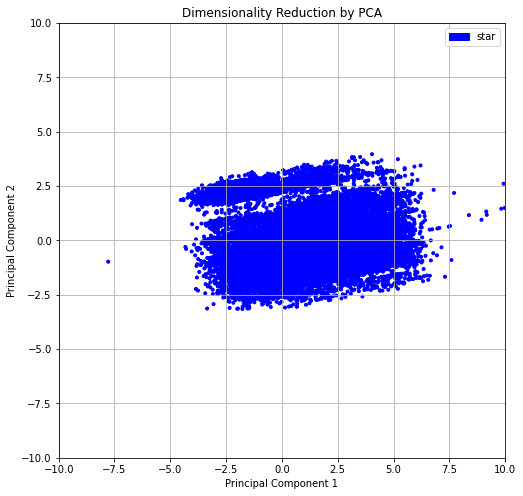

In [ ]:
fig_pca_s, ax_pca_s = plt.subplots(figsize=(8,8))
ax_pca_s.scatter(pca_components[y == 'STAR',0], pca_components[y == 'STAR',1], c=colors_class[y == 'STAR'],  marker='.')
ax_pca_s.set_xlim(-10,10)
ax_pca_s.set_ylim(-10,10)
blue_patch = mpatches.Patch(color='blue', label='star')
ax_pca_s.legend(handles=[blue_patch])
plt.grid()
plt.title("Dimensionality Reduction by PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

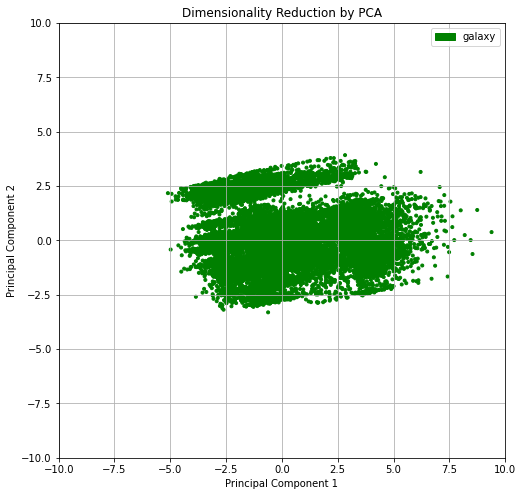

In [ ]:
fig_pca_g, ax_pca_g = plt.subplots(figsize=(8,8))
ax_pca_g.scatter(pca_components[y == 'GALAXY',0], pca_components[y == 'GALAXY',1], c=colors_class[y == 'GALAXY'],  marker='.')
ax_pca_g.set_xlim(-10,10)
ax_pca_g.set_ylim(-10,10)
green_patch = mpatches.Patch(color='green', label='galaxy')
ax_pca_g.legend(handles=[green_patch])
plt.grid()
plt.title("Dimensionality Reduction by PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

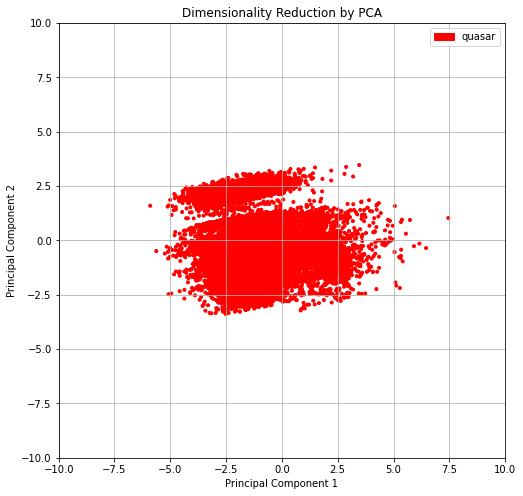

In [ ]:
fig_pca_q, ax_pca_q = plt.subplots(figsize=(8,8))
ax_pca_q.scatter(pca_components[y == 'QSO',0], pca_components[y == 'QSO',1], c=colors_class[y == 'QSO'],  marker='.')
ax_pca_q.set_xlim(-10,10)
ax_pca_q.set_ylim(-10,10)
red_patch = mpatches.Patch(color='red', label='quasar')
ax_pca_q.legend(handles=[red_patch])
plt.grid()
plt.title("Dimensionality Reduction by PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

- Even the figures with the individual classes show the different classes largely occupying the same space. However, there does appear to be some separation in the first component, espeically between quasars at the lower end and stars and galaxies at the higher end.

- We can use k-means clustering to investigate if the observations can be organized into groups based on similarity. This method requires us to specify the number of clusters. We use k = 3 clusters, because we are aware that is the correct answer.

In [ ]:
# set the number of clusters
nc = 3

# define k-means model (uses defaults values of n_init=10, max_iter=300, tol=1e-4)
kmeans_cluster = KMeans(n_clusters=nc, random_state=rs)

# fit the k-means model
kmeans_cluster.fit(X)
print('The number of iterations used for k-means is {}.'.format(kmeans_cluster.n_iter_))

# determine predicted labels
y_pred_kmeans = kmeans_cluster.predict(X)

The number of iterations used for k-means is 7.


- In y_pred_kmeans, the k-means method produced labels of 0, 1, and 2. However, in y we have labels of 'STAR', 'GALAXY', and 'QSO'. 
- Recall that the number of occurences in y was deliberately balanced:

In [ ]:
print('In y, the count for label \'STAR\' is {}.'.format(y.str.count('STAR').sum()))
print('In y, the count for label \'GALAXY\' is {}.'.format(y.str.count('GALAXY').sum()))
print('In y, the count for label \'QSO\' is {}.'.format(y.str.count('QSO').sum()))

In y, the count for label 'STAR' is 18961.
In y, the count for label 'GALAXY' is 18961.
In y, the count for label 'QSO' is 18961.


- What is the count of each label in y_pred_kmeans?:

In [ ]:
y_pred_kmeans_unique_values, y_pred_kmeans_unique_counts = np.unique(y_pred_kmeans, return_counts=True)
print('In y_pred_kmeans, the count for label {} is {}.'.format(y_pred_kmeans_unique_values[0],y_pred_kmeans_unique_counts[0]))
print('In y_pred_kmeans, the count for label {} is {}.'.format(y_pred_kmeans_unique_values[1],y_pred_kmeans_unique_counts[1]))
print('In y_pred_kmeans, the count for label {} is {}.'.format(y_pred_kmeans_unique_values[2],y_pred_kmeans_unique_counts[2]))

In y_pred_kmeans, the count for label 0 is 19638.
In y_pred_kmeans, the count for label 1 is 24763.
In y_pred_kmeans, the count for label 2 is 12482.


- We do not know how these clusters correspond to the labels, so we determined the arrangement that produces the optimal match between the known and predicted labels: 

In [ ]:
y_pred_kmeans_str = y_pred_kmeans.astype(str)
y_pred_kmeans_str[y_pred_kmeans == 0] = 'STAR'
y_pred_kmeans_str[y_pred_kmeans == 2] = 'GALAXY'
y_pred_kmeans_str[y_pred_kmeans == 1] = 'QSO'

np.count_nonzero(y.to_numpy() == y_pred_kmeans_str)

27198

- Even at the optimal arrangement, only 27198/(3*18961) = 0.478 or 47.8% of labels are predicted correctly. 

- The adjusted Rand index (ARI) can can be used to measure how well K-means clustering performs when we know the correct class assignment. It compares how pairs of data points relate in the correct class assignment and in the cluster assignment. The ARI has a value close to 0.0 for random labeling and exactly 1.0 when the clustering is perfect.

In [ ]:
print('Adjusted Rand Index: %0.3f' % metrics.adjusted_rand_score(y, y_pred_kmeans_str))

Adjusted Rand Index: 0.090


- The ARI for K-means is much closer to 0 than 1, so K-means does not do much better than random assignment.

- We can plot the data using the first two PCA components:

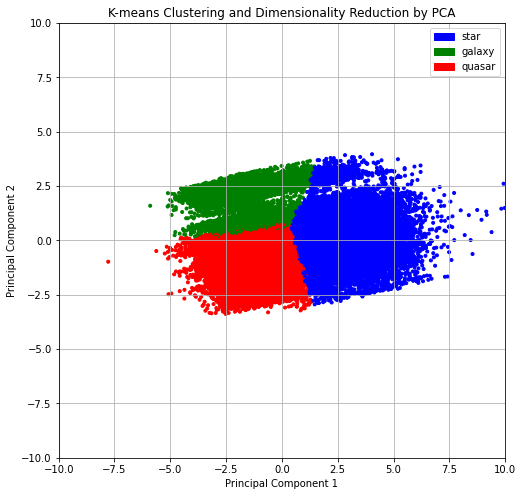

In [ ]:
colors_class_kmeans = np.empty(y_pred_kmeans_str.shape[0], dtype=str)
colors_class_kmeans[y_pred_kmeans_str == 'STAR'] = 'b'
colors_class_kmeans[y_pred_kmeans_str == 'GALAXY'] = 'g'
colors_class_kmeans[y_pred_kmeans_str == 'QSO'] = 'r'

fig_pca_kmeans, ax_pca_kmeans = plt.subplots(figsize=(8,8))
ax_pca_kmeans.scatter(pca_components[:,0], pca_components[:,1], c=colors_class_kmeans,  marker='.')
ax_pca_kmeans.set_xlim(-10,10)
ax_pca_kmeans.set_ylim(-10,10)
blue_patch = mpatches.Patch(color='blue', label='star')
green_patch = mpatches.Patch(color='green', label='galaxy')
red_patch = mpatches.Patch(color='red', label='quasar')
ax_pca_kmeans.legend(handles=[blue_patch, green_patch, red_patch])
plt.grid()
plt.title("K-means Clustering and Dimensionality Reduction by PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

- The K-means clustering assignments deviate fairly significantly from the known assignments. It does not appear that clustering is a useful method here.

- The primary result from the unsupervised learning methods is that there is an ability to include much of the information from all of the features in a smaller number of principal components, if it were to be needed for supervised learning modeling. We choose not to use PCA in order to maintain an understanding about which of the features are most important, and because we determine below that we do not need to use reduced dimensions to have a successful model.

####**5. Model Preparation: Training/Test Split and Feature Selection**

For modeling purposes, we split data into training and test sets. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = rs)

The training set is used to build the models and the test set is used to evaluate the models.

We investigate how correlated the features are with each other, and when a feature pair exceeds a specified correlation threshold, exclude one of the features from modeling. This is the use of a filter method for feature selection. We determined above that none of the features are normally distributed, so we use the the Spearman rank-order correlation coefficient. Unlike the Pearson correlation, the Spearman correlation does not assume that the data are normally distributed.

Obtain the correlation matrix and p-values matrix for the features:

In [ ]:
# correlation matrix and p-values matrix
X_train_sp_corr, X_train_sp_pval = stats.spearmanr(X_train)
# put into dataframes
X_train_sp_abs_corr_df = pd.DataFrame(abs(X_train_sp_corr), index = X_train.columns, columns = X_train.columns)
X_train_sp_pval_df = pd.DataFrame(X_train_sp_pval, index = X_train.columns, columns = X_train.columns)

We can view the absolute correlation matrix with a heatmap:

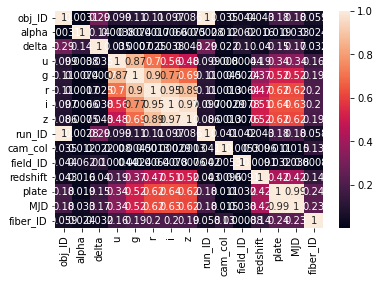

In [ ]:
# heatmap
sn.heatmap(abs(X_train_sp_abs_corr_df), annot=True)
plt.show()

The heatmap shows that obj_ID is perfectly correlated with run_ID. There are some larger correlations among the magnitudes in the different filters (u,g,r,i,z), which is not that surprising because a brighter object may be brighter across a range of electromagnetic frequencies. Features plate and MJD have larger correlations with some of the magnitudes, and plate and MJD are highly correlated with each other. 

Let's arrange the absolute correlations in descending order and include their p-values to consdier significance:

In [ ]:
# define empty DataFrame
features_abs_correlations_pvals = pd.DataFrame(columns = ['feature_1', 'feature_2', 'abs_correlation', 'p-value'])

# fill data DataFrame with absolute correlations and paired names of features 
for i in range(X_train.columns.size):
  for j in range(X_train.columns.size):
    features_abs_correlations_pvals = features_abs_correlations_pvals.append({'feature_1': X_train.columns[i], 
                                                                              'feature_2': X_train.columns[j], 
                                                                              'abs_correlation': X_train_sp_abs_corr_df.iloc[i,j],
                                                                              'p-value': X_train_sp_pval_df.iloc[i,j]}, 
                                                                              ignore_index = True)

# sort
features_abs_correlations_pvals_sorted = features_abs_correlations_pvals.sort_values(by='abs_correlation', ascending=False)

# select absolute correlations to look at 
# (leave out autocorrelations which are 1 and only every other row after that 
#  because of mirror image across autocorrelation line)
features_abs_correlations_pvals_sorted_sel = features_abs_correlations_pvals_sorted.iloc[X_train.columns.size+1::2,:]

In [ ]:
print(features_abs_correlations_pvals_sorted_sel.shape)

(105, 4)


In [ ]:
print(features_abs_correlations_pvals_sorted_sel.loc[features_abs_correlations_pvals_sorted_sel['p-value'] <= 0.01].shape)

(81, 4)


There are 81 of the 105 correlations that are significant at the 1% level. Let's look at the top correlations (> 0.5): 

In [ ]:
features_abs_correlations_pvals_sorted_sel[0:21]

,feature_1,feature_2,abs_correlation,p-value
8,obj_ID,run_ID,0.999943,0.0
207,MJD,plate,0.991851,0.0
97,i,z,0.971249,0.0
95,i,r,0.949284,0.0
65,g,r,0.904705,0.0
110,z,r,0.889163,0.0
49,u,g,0.872539,0.0
66,g,i,0.773507,0.0
50,u,r,0.702829,0.0
67,g,z,0.688200,0.0


We see that there are a number of large and significant correlations here. Features obj_ID and run_ID are highly correlated. Features MJD and plate are also highly correlated. We remove run_ID and MJD. Even though there are high correlations among the different filter magnitudes, starting to remove them seems to be a concerning concept so for now they are all kept in. Therefore, we can state that our correlation cutoff is 0.975.

In [ ]:
# drop features
cols_drop_high_abs_corr = np.array(['run_ID','MJD'])
X_train_rdcd = X_train.copy()
X_test_rdcd = X_test.copy()
X_train_rdcd = X_train_rdcd.drop(columns=cols_drop_high_abs_corr)
X_test_rdcd = X_test_rdcd.drop(columns=cols_drop_high_abs_corr)

####**6. Model: Logistic Regression**

The first model we build is a linear logistic regression model. The initial model uses these parameters in LogisticRegresssion:
- 'solver': This is the algorithm to use in the optimization problem. The default is 'lbfgs' (Large-scale Bound-constrained Optimization), which is a more complex variation of the gradient descent algorithm.
- 'penalty': The penalty parameter controls regularization. Regularization is used to combat overfitting. Regularization has the effect of reducing the variance between coefficients. This means that the model does not fit the training data quite as well, but it should generalize to unseen data better. The default is 'l2', which adds a L2 penalty term. This is a type of embedded feature selection.
- 'max_iter': This is the maximum number of iterations taken for the solver to converge. The default is 100. Using the default of 100, we received a warning message that lbfgs failed to converge becauase the total number of iteration reached the limit. Therefore, we had to immediately increase it to 150.

In [ ]:
lgr_initial = LogisticRegression(solver = 'lbfgs', random_state = rs, max_iter = 150)

Fit the initial model to the training data:

In [ ]:
start_time_lgr_initial = time.time()
lgr_initial.fit(X_train_rdcd, y_train)
print("--- %s seconds ---" % (time.time() - start_time_lgr_initial))

--- 7.620094060897827 seconds ---


Running the initial model fit takes approximately 4 seconds.

Let's determine the number of iterations used and the score (the mean accuracy):

In [ ]:
n_iter_initial = lgr_initial.n_iter_[0]
score_initial = lgr_initial.score(X_train_rdcd, y_train)
print('Number of iterations: ', n_iter_initial)
print('Score on training data: ', score_initial)

Number of iterations:  135
Score on training data:  0.9477431547488243


The initial logistic regression completed at 135 of 150 available iterations. The mean accuracy of the model on the training data is 0.947743.

Let's look at the coefficients to make sure there are no extreme values:

In [ ]:
lgr_initial.coef_[0]

array([ 7.51591967e-03, -3.07837118e-02, -7.35761646e-02,  1.79362199e-01,
        7.32543109e-01,  3.57889721e-01, -1.17538254e+00, -7.12338237e-02,
       -4.03280816e-02,  3.44892754e-02,  1.51356225e+01, -7.40415726e-02,
        1.07019401e-02])

The coefficient values are acceptable.

In [ ]:
X_train_rdcd.shape

(45506, 13)

We will use 10-fold cross validation to train the model. That means that in each fold, each data split will have 45,506/10 ~= 4,551 data points. By holding out one split in each fold for testing, we can test the performance of the logistic regression for that fold, and that will allow us to optimize the parameters.

In [ ]:
cv_folds = 10
start_time_lgr_initial_cv = time.time()
results_lgr_initial_cv = cross_validate(lgr_initial, X_train_rdcd, y_train, cv=cv_folds, return_estimator=True)
print("--- %s seconds ---" % (time.time() - start_time_lgr_initial_cv))

--- 29.127327919006348 seconds ---


Running the initial model cross validation fits takes approximately 33 seconds.

Look at n_iter and scores from each fold:

In [ ]:
n_iters_lgr_initial_cv = np.empty(cv_folds, dtype=int) 
for i in range(cv_folds):
  n_iters_lgr_initial_cv[i] = results_lgr_initial_cv['estimator'][i].n_iter_[0]

scores_lgr_initial_cv  = results_lgr_initial_cv['test_score']

In [ ]:
print('Number of Iterations:')
print(n_iters_lgr_initial_cv)
print('Scores:')
print(scores_lgr_initial_cv)
print('Mean Score:')
print(scores_lgr_initial_cv.mean())
print('Standard Deviation Score:')
print(scores_lgr_initial_cv.std())

Number of Iterations:
[107 125  97 120 112 135 116 110 121 109]
Scores:
[0.94418809 0.94396836 0.94726434 0.94968139 0.94660514 0.94946166
 0.94461538 0.95230769 0.94549451 0.95010989]
Mean Score:
0.9473696446379375
Standard Deviation Score:
0.0027386605864632005


Across all folds, the number of iterations varies from 97 to 135. The mean score is 0.947370 with a very small standard deviation of 0.002739.

We will now consider different solvers, 'sag' and 'saga', which are supposed to perform better for larger datasets. The 'sag' solver converged within the default max_iter of 100, but max_iter had to be increased to 175 for 'saga'.

In [ ]:
lgr_sag = LogisticRegression(solver = 'sag', random_state = rs)

lgr_saga = LogisticRegression(solver = 'saga', random_state = rs, max_iter = 175)

In [ ]:
start_time_lgr_sag_cv = time.time()
results_lgr_sag = cross_validate(lgr_sag, X_train_rdcd, y_train, cv=cv_folds, return_estimator=True)
print("--- %s seconds ---" % (time.time() - start_time_lgr_sag_cv))

start_time_lgr_saga_cv = time.time()
results_lgr_saga = cross_validate(lgr_saga, X_train_rdcd, y_train, cv=cv_folds, return_estimator=True)
print("--- %s seconds ---" % (time.time() - start_time_lgr_saga_cv))

--- 18.322862148284912 seconds ---
--- 37.35772180557251 seconds ---


In [ ]:
n_iters_lgr_sag = np.empty(cv_folds, dtype=int) 
n_iters_lgr_saga = np.empty(cv_folds, dtype=int) 
for i in range(cv_folds):
   n_iters_lgr_sag[i] = results_lgr_sag['estimator'][i].n_iter_[0]
   n_iters_lgr_saga[i] = results_lgr_saga['estimator'][i].n_iter_[0]

scores_lgr_sag = results_lgr_sag['test_score']
scores_lgr_saga = results_lgr_saga['test_score']

In [ ]:
print('Number of Iterations (SAG):')
print(n_iters_lgr_sag)
print('Number of Iterations (SAGA):')
print(n_iters_lgr_saga)
print('Scores (SAG):')
print(scores_lgr_sag)
print('Scores (SAGA):')
print(scores_lgr_saga)
print('Mean Score (SAG):')
print(scores_lgr_sag.mean())
print('Mean Score (SAGA):')
print(scores_lgr_saga.mean())
print('Standard Deviation Score (SAG):')
print(scores_lgr_sag.std())
print('Standard Deviation Score (SAGA):')
print(scores_lgr_saga.std())

Number of Iterations (SAG):
[88 88 89 88 88 88 76 88 88 88]
Number of Iterations (SAGA):
[171 169 171 170 170 170 152 170 170 170]
Scores (SAG):
[0.94418809 0.94396836 0.94726434 0.94968139 0.94660514 0.94946166
 0.94461538 0.95230769 0.94549451 0.95010989]
Scores (SAGA):
[0.94418809 0.94396836 0.94726434 0.94968139 0.94638541 0.94946166
 0.94461538 0.95230769 0.94549451 0.94989011]
Mean Score (SAG):
0.9473696446379375
Mean Score (SAGA):
0.9473256934232543
Standard Deviation Score (SAG):
0.0027386605864632005
Standard Deviation Score (SAGA):
0.0027241761019073966


The 'sag' cross validation takes about as long to run as 'lbfgs', but with a smaller number of iterations. The 'saga' cross validation takes longer to run and uses a larger number of iterations than both of the other methods. For the means score, 'lbfgs' and 'sag' produce the exact same result of 0.947370, and 'saga' is very slightly lower at 0.947326. Based on these results, we use the default 'lbfgs' for the remainder of our regressions.

We now look at the impact of varying parameter 'C', which is the inverse of regularization strength that defaults to 1. Smaller values specify stronger regularization. At some spread out values of C (0.55, 0.65, 0.75, 0.95), the fits failed to converge at max_iter=150, so it was necessary to increase max_ iter to 175.

In [ ]:
# make an array of C values to check
c_vals = np.arange(0.05, 1.55, 0.05) # 29 elements

train_accuracy_vec = np.empty(c_vals.size, dtype=float)

start_time_lgr_C_loop = time.time()
for i in range(c_vals.size):
   print('The current c_val is {}.'.format(c_vals[i]))
   lgr_C_i = LogisticRegression(solver='lbfgs', random_state=rs, max_iter = 175, C=c_vals[i])
   results_lgr_C_i = cross_validate(lgr_C_i, X_train_rdcd, y_train, cv=cv_folds, return_estimator=True)
   scores_lgr_C_i = results_lgr_C_i['test_score']
   train_accuracy_vec[i] = scores_lgr_C_i.mean()
print("--- %s seconds ---" % (time.time() - start_time_lgr_C_loop))

The current c_val is 0.05.
The current c_val is 0.1.
The current c_val is 0.15000000000000002.
The current c_val is 0.2.
The current c_val is 0.25.
The current c_val is 0.3.
The current c_val is 0.35000000000000003.
The current c_val is 0.4.
The current c_val is 0.45.
The current c_val is 0.5.
The current c_val is 0.55.
The current c_val is 0.6000000000000001.
The current c_val is 0.6500000000000001.
The current c_val is 0.7000000000000001.
The current c_val is 0.7500000000000001.
The current c_val is 0.8.
The current c_val is 0.8500000000000001.
The current c_val is 0.9000000000000001.
The current c_val is 0.9500000000000001.
The current c_val is 1.0.
The current c_val is 1.05.
The current c_val is 1.1.
The current c_val is 1.1500000000000001.
The current c_val is 1.2000000000000002.
The current c_val is 1.2500000000000002.
The current c_val is 1.3.
The current c_val is 1.35.
The current c_val is 1.4000000000000001.
The current c_val is 1.4500000000000002.
The current c_val is 1.50000

The above takes approximately 1000 s. Let's plot the accuracies as a function of C:

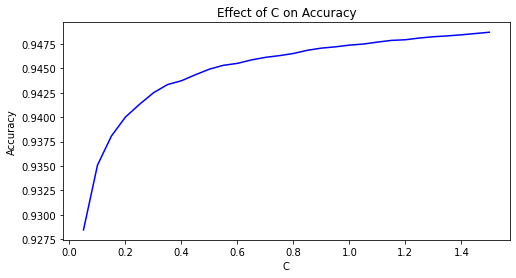

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(c_vals, train_accuracy_vec, '-b', label='Train Accuracy')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Effect of C on Accuracy')
plt.show()

Because the highest C has the highest accuracy, we check if that just continues if we look at higher values or if we can find a maximum: 

In [ ]:
# make an array of C values to check
c_vals_large = np.arange(1, 5.5, 0.5) # 29 elements

train_accuracy_large_vec = np.empty(c_vals_large.size, dtype=float)

start_time_lgr_C_loop = time.time()
for i in range(c_vals_large.size):
   print('The current c_val is {}.'.format(c_vals_large[i]))
   lgr_C_large_i = LogisticRegression(solver='lbfgs', random_state=rs, max_iter = 175, C=c_vals_large[i])
   results_lgr_C_large_i = cross_validate(lgr_C_large_i, X_train_rdcd, y_train, cv=cv_folds, return_estimator=True)
   scores_lgr_C_large_i = results_lgr_C_large_i['test_score']
   train_accuracy_large_vec[i] = scores_lgr_C_large_i.mean()
print("--- %s seconds ---" % (time.time() - start_time_lgr_C_loop))

The current c_val is 1.0.
The current c_val is 1.5.
The current c_val is 2.0.
The current c_val is 2.5.
The current c_val is 3.0.
The current c_val is 3.5.
The current c_val is 4.0.
The current c_val is 4.5.
The current c_val is 5.0.
--- 282.67248010635376 seconds ---


The above takes approximately 300 s. Let's plot the accuracies as a function of C:

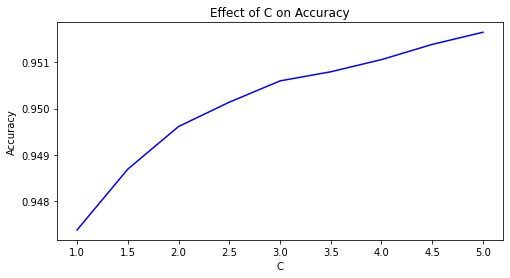

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(c_vals_large, train_accuracy_large_vec, '-b', label='Train Accuracy')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Effect of C on Accuracy')
plt.show()

The accuracy just keeps increasing with increasing C which suggests that the larger C values may be allowing overfitting. Because the results of varying C are inconclusive, we just keep it at the default value of 1. 

After this testing, the optimal model thus ends up being the same as the initial model, but we are just more explicit about the settings here.  

We now fit the optimal regression model to all of the training data:

In [ ]:
lgr_opt = LogisticRegression(solver = 'lbfgs', random_state = rs, max_iter = 150, penalty='l2', C=1)

In [ ]:
start_time_lgr_opt = time.time()
lgr_opt.fit(X_train_rdcd, y_train)
print("--- %s seconds ---" % (time.time() - start_time_lgr_opt))

--- 3.6665406227111816 seconds ---


Running the optimal model fit takes approximately 7 seconds.

Let's determine the number of iterations used and the score (the mean accuracy) for the training data:

In [ ]:
n_iter_opt = lgr_opt.n_iter_[0]
score_opt = lgr_opt.score(X_train_rdcd, y_train)
print('Number of iterations: ', n_iter_opt)
print('Score on training data: ', score_opt)

Number of iterations:  135
Score on training data:  0.9477431547488243


The initial logistic regression completed at 135 of 150 available iterations. The mean accuracy of the model on the training data is 0.947743.

Let's look at the coefficients to make sure there are no extreme values:

In [ ]:
lgr_opt.coef_[0]

array([ 7.51591967e-03, -3.07837118e-02, -7.35761646e-02,  1.79362199e-01,
        7.32543109e-01,  3.57889721e-01, -1.17538254e+00, -7.12338237e-02,
       -4.03280816e-02,  3.44892754e-02,  1.51356225e+01, -7.40415726e-02,
        1.07019401e-02])

The coefficient values are acceptable. Let's determine the terms with the largest coefficients:

In [ ]:
features_coefficients_df = pd.DataFrame({'features': np.array(X_train_rdcd.columns), 
                                         'coefficients': lgr_opt.coef_[0]})

features_coefficients_df_sort_max_pos = features_coefficients_df.loc[features_coefficients_df['coefficients'] >= 0].sort_values(by='coefficients', ascending=False)
features_coefficients_df_sort_max_neg = features_coefficients_df.loc[features_coefficients_df['coefficients'] <  0].sort_values(by='coefficients')

For the positive coefficients, here is their order in descending size: 

In [ ]:
features_coefficients_df_sort_max_pos

,features,coefficients
10,redshift,15.135622
4,g,0.732543
5,r,0.357890
3,u,0.179362
9,field_ID,0.034489
12,fiber_ID,0.010702
0,obj_ID,0.007516


In [ ]:
features_coefficients_df_sort_max_neg

,features,coefficients
6,i,-1.175383
11,plate,-0.074042
2,delta,-0.073576
7,z,-0.071234
8,cam_col,-0.040328
1,alpha,-0.030784


The most important feature is redshift, followed by i (near infrared), g (green), r (red), and u (ultraviolet). The coefficients for other features including z (infrared) and properties of where and how the observations were made are smaller (in an absolute sense). That some of the coefficients are much larger than the others helps to explain what we saw with PCA where the first 2 components explain more than 50% of the variance.

We now apply the model to the test data:

In [ ]:
score_opt_test = lgr_opt.score(X_test_rdcd, y_test)
print('Score on test data: ', score_opt_test)

Score on test data:  0.9467346400632856


The score on the test data is 0.946735, which is slightly less than the 0.947743 we obtained for the training data. The logistic regression model appears to perform similarly for data within and outside the training data.

Let's look at the dummy classifier to calculate the accuracy of always assigning the majority class and then compare this result to the result of the logistic regression classifier above. This dummy classifier gives a null accuracy baseline to which we can compare our model's performance.

In [ ]:
dummy = DummyClassifier(strategy = 'most_frequent')
dummy.fit(X_train_rdcd, y_train)
score_dum_train = dummy.score(X_train_rdcd, y_train)
score_dum_test = dummy.score(X_test_rdcd, y_test)
print('Dummy accuracy for training data: ', score_dum_train)
print('Dummy accuracy for test data: ', score_dum_test)
print('Difference in accuracies for training data: ', score_opt-score_dum_train)
print('Difference in accuracies for test data: ', score_opt_test-score_dum_test)

Dummy accuracy for training data:  0.33382411110622773
Dummy accuracy for test data:  0.3313703085171838
Difference in accuracies for training data:  0.6139190436425965
Difference in accuracies for test data:  0.6153643315461017


The dummy classifer score for the training data is 0.333824 and for the test data is 0.331370. A value close to 0.33 is expected, because the classes were deliberately balanced to have approximately 1/3 in of each class.The logistic regression model performs substantially better than the dummy classifier.

Although it is important to have good accuracy, accuracy does not tell the whole story. The confusion matrix provides a deeper understanding of what is going on with a classification model's performance by showing how things are classified. It reveals which data points are classified correctly and which ones are not. Let's determine the confusion matrix for the test data:

In [ ]:
lgr_opt_predictions = lgr_opt.predict(X_test_rdcd)
lgr_opt_confusion = confusion_matrix(y_test, lgr_opt_predictions, labels=['STAR', 'GALAXY', 'QSO'])
# put into dataframe
lgr_opt_confusion_df = pd.DataFrame(lgr_opt_confusion, index = ['STAR', 'GALAXY', 'QSO'], columns = ['STAR', 'GALAXY', 'QSO'])

Let's confirm how the confusion matrix is configured:

In [ ]:
print('The sum over the rows is\n{}.'.format(lgr_opt_confusion_df.sum(axis = 0)))
print('The sum over the columns is\n{}.'.format(lgr_opt_confusion_df.sum(axis = 1)))
print('The counts of the true classes are\n{}.'.format(y_test.value_counts()[['STAR', 'GALAXY','QSO']]))
print('The counts of the predicted classes are\n{}.'.format(pd.Series(lgr_opt_predictions).value_counts()[['STAR', 'GALAXY','QSO']]))

The sum over the rows is
STAR      3945
GALAXY    3794
QSO       3638
dtype: int64.
The sum over the columns is
STAR      3775
GALAXY    3832
QSO       3770
dtype: int64.
The counts of the true classes are
STAR      3775
GALAXY    3832
QSO       3770
Name: class, dtype: int64.
The counts of the predicted classes are
STAR      3945
GALAXY    3794
QSO       3638
dtype: int64.


Therefore, the row label tells us the true class and the column tells us the predicted class.

In [ ]:
lgr_opt_confusion_df

,STAR,GALAXY,QSO
STAR,3774,0,1
GALAXY,164,3514,154
QSO,7,280,3483


For stars, all but 1 out of 3,775 are predicted correctly. Out of 3,832 true galaxies, 3,514 are predicted correctly, and roughly equal small numbers, 164 and 154, are predicted as stars and quasars, respectively. Out of 3,770 true quasars, 3,483 are prediced correctly, and only 7 are predicted as stars, and 280 as galaxies.

We can also look at the area under the receiver operating characteristic curve (ROC AUC) to further check on the logistic regression model:

In [ ]:
lgr_opt_probs = lgr_opt.predict_proba(X_test_rdcd)
lgr_opt_auc_ovr = roc_auc_score(y_test, lgr_opt_probs,  multi_class='ovr')
print('The area under the ROC curve using one-vs-rest (ovr) is: {:.6f}.'.format(lgr_opt_auc_ovr))
lgr_opt_auc_ovo = roc_auc_score(y_test, lgr_opt_probs,  multi_class='ovo')
print('The area under the ROC curve using one-vs-one (ovo) is: {:.6f}.'.format(lgr_opt_auc_ovo))

The area under the ROC curve using one-vs-rest (ovr) is: 0.988049.
The area under the ROC curve using one-vs-one (ovo) is: 0.988081.


ROC AUC was determined using both one-vs-rest, which computes the AUC of each class against the rest, and one-vs-one, which computes the average AUC of all possible pairwise combinations of classes. They are very similar and the AUC is large.

This is pretty much all we can do with the logistic regression model, so we move onto the decision tree, which provides a nonlinear method for modeling the data. 

####**7. Model: Decision Tree**

The next model that we will try is decision tree, and work to build the best decision tree possible.



As a reminder, look at how many rows and features are present: 

In [ ]:
X_train_rdcd.shape

(45506, 13)

First, we initialize the tree with default specifications, except for criterion:
*   criterion = 'entropy': The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.
*   In the course, the focus was put on entropy as the criterion, so we start by using it here.

In [ ]:
decision_tree_no_params = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state = rs
)

We use 10-fold cross validation to train the model. That means that in each fold, each data split will have 45,506/10 ~= 4,551 data points. By holding out one split in each fold for testing, we can test the performance of the tree for that fold, and that will allow us to optimize the tree parameters.

Carry out 10-fold cross validation:

In [ ]:
cv_folds = 10
start_time_dt_no_params = time.time()
results_dt_no_params = cross_validate(decision_tree_no_params, X_train_rdcd, y_train, cv=cv_folds, return_estimator=True)
print("--- %s seconds ---" % (time.time() - start_time_dt_no_params))

--- 8.643065452575684 seconds ---


The above takes approximately 10 seconds.

Look at scores for and characteristics of the decision trees. The scores returned are the mean accuracy for each fold.

In [ ]:
scores_dt_no_params = results_dt_no_params['test_score']

In [ ]:
depths_dt_no_params = np.empty(cv_folds, dtype=int)
n_leaves_dt_no_params = np.empty(cv_folds, dtype=int)
for i in range(cv_folds):
  depths_dt_no_params[i] = results_dt_no_params['estimator'][i].get_depth()
  n_leaves_dt_no_params[i] = results_dt_no_params['estimator'][i].get_n_leaves()

In [ ]:
print('Scores:')
print(scores_dt_no_params)
print('Tree Depths:')
print(depths_dt_no_params)
print('Number of Leaves:')
print(n_leaves_dt_no_params)

Scores:
[0.95956933 0.95781147 0.9641837  0.96506262 0.95693254 0.96044825
 0.95912088 0.95736264 0.95846154 0.96065934]
Tree Depths:
[24 24 27 23 22 26 22 29 26 28]
Number of Leaves:
[921 933 945 972 961 959 944 961 929 923]


The scores do not vary much among the folds. Looking at these depths and numbers of leaves, these trees are likely too complex and are overfitting the test set in each fold. Let us try to adjust some of the parameters for DecisionTreeClassifier. We start with max_depth, which is the maximum depth of the tree. Above with the default parameters, the nodes were just expanded until all leaves were pure or contained less than 2 samples. We now back off of doing that.

In [ ]:
md = 9

decision_tree_md = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state = rs,
    max_depth = md
)

Carry out 10-fold cross validation:

In [ ]:
start_time_dt_md = time.time()
results_dt_md = cross_validate(decision_tree_md, X_train_rdcd, y_train, cv=cv_folds, return_estimator=True)
print("--- %s seconds ---" % (time.time() - start_time_dt_md))

--- 7.27623724937439 seconds ---


Look at mean and standard deviation of scores for the decision trees:

In [ ]:
scores_dt_md = results_dt_md['test_score']

In [ ]:
print('Mean Score:')
print(scores_dt_md.mean())
print('Standard Deviation Score:')
print(scores_dt_md.std())

Mean Score:
0.9697621051767393
Standard Deviation Score:
0.0027533217561920937


These are the results of varying max_depth (md) above:

| Max. Depth | Mean Score | Std. Dev. Score | Fit Time (s) |
| :-: | :-: | :-: | :-: |
|  1 | 0.638845 | 0.006743 |  2.14 |
|  2 | 0.927394 | 0.003269 |  3.18 |
|  3 | 0.927460 | 0.003327 |  5.09 |
|  4 | 0.948029 | 0.004209 |  5.32 |
|  5 | 0.957741 | 0.004002 |  6.19 |
|  6 | 0.962115 | 0.004331 |  9.07 |
|  7 | 0.965982 | 0.003580 |  9.03 |
|  8 | 0.969696 | 0.002375 | 10.06 |
|  9 | 0.969762 | 0.002753 |  8.55 |
| 10 | 0.969432 | 0.002525 |  9.57 |
| 11 | 0.968070 | 0.002810 |  9.81 |
| 12 | 0.966510 | 0.002762 | 13.45 |
| 13 | 0.964950 | 0.003347 |  9.58 |
| 14 | 0.963609 | 0.002895 |  9.97 |
| 15 | 0.962576 | 0.003689 | 10.90 |

Based on the mean score, the optimal max_depth is 9. At the depths close to 9, the standard deviations are much lower than the means, so the various trees have similar performance.

The next parameter to test is min_samples_leaf, which is the minimum number of samples required to be at a leaf node; a split point at any depth will only be considered if it keeps at least min_samples_leaf training samples in each of the left and right branches. It defaults to 1, and increasing it may have the effect of smoothing the model.

In [ ]:
md = 9

msl = 7

decision_tree_md_msl = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state = rs,
    max_depth = md,
    min_samples_leaf = msl
)

Carry out 10-fold cross validation:

In [ ]:
start_time_dt_md_msl = time.time()
results_dt_md_msl = cross_validate(decision_tree_md_msl, X_train_rdcd, y_train, cv=cv_folds, return_estimator=True)
print("--- %s seconds ---" % (time.time() - start_time_dt_md_msl))

--- 7.401469945907593 seconds ---


Look at mean and standard deviation of scores for the decision trees:

In [ ]:
scores_dt_md_msl = results_dt_md_msl['test_score']

print('Mean Score:')
print(scores_dt_md_msl.mean())
print('Standard Deviation Score:')
print(scores_dt_md_msl.std())

Mean Score:
0.9699818419330615
Standard Deviation Score:
0.003093788456155507


These are the results of varying min_samples_leaf (msl) above, while holding max_depth (md) at the optimal value of 9:

| Min. Samples Leaf | Mean Score | Std. Dev. Score | Fit Time (s) |
| :-: | :-: | :-: | :-: |
|    1 | 0.969762 | 0.002753 |  8.32 |
|    2 | 0.969740 | 0.002638 |  8.33 |
|    3 | 0.969564 | 0.002826 |  8.37 |
|    4 | 0.969323 | 0.002721 |  9.41 |
|    5 | 0.969498 | 0.003149 |  8.29 |
|    6 | 0.969542 | 0.003133 |  8.41 |
|    7 | 0.969982 | 0.003094 |  9.98 |
|    8 | 0.969696 | 0.003306 |  8.64 |
|    9 | 0.969916 | 0.002967 | 13.70 |
|   10 | 0.969476 | 0.003053 |  8.32 |
|   11 | 0.969410 | 0.003308 |  9.03 |
|   12 | 0.969345 | 0.003423 |  8.04 |
|   13 | 0.969454 | 0.003644 |  8.04 |
|   14 | 0.969520 | 0.003723 |  8.01 |
|   15 | 0.969718 | 0.003463 |  8.01 |
|   16 | 0.969454 | ----- | ----- |
|   17 | 0.969718 | ----- | ----- |
|   18 | 0.969674 | ----- | ----- |
|   19 | 0.969586 | ----- | ----- |
|   20 | 0.969432 | 0.003071 |  8.04 |
|   21 | 0.969608 | ----- | ----- |
|   22 | 0.969696 | ----- | ----- |
|   23 | 0.969718 | ----- | ----- |
|   24 | 0.969828 | ----- | ----- |
|   25 | 0.969762 | 0.003390 |  7.98 |
|   26 | 0.969740 | ----- | ----- |
|   27 | 0.969828 | ----- | ----- |
|   28 | 0.969718 | ----- | ----- |
|   29 | 0.969630 | ----- | ----- |
|   30 | 0.969476 | 0.003412 |  7.95 |
|   31 | 0.969520 | ----- | ----- |
|   32 | 0.969586 | ----- | ----- |
|   33 | 0.969542 | ----- | ----- |
|   34 | 0.969520 | ----- | ----- |
|   35 | 0.969762 | 0.003390 |  8.37 |
|   36 | 0.969454 | ----- | ----- |
|   37 | 0.969476 | ----- | ----- |
|   38 | 0.969432 | ----- | ----- |
|   39 | 0.969235 | ----- | ----- |
|   40 | 0.969323 | 0.003844 |  8.13 |
|   45 | 0.968971 | 0.003703 |  7.86 |
|   50 | 0.969125 | 0.003717 |  7.95 |
|   55 | 0.969125 | 0.003765 |  7.84 |
|   60 | 0.969059 | 0.003626 |  7.74 |
|   70 | 0.968861 | 0.003612 |  8.21 |
|   80 | 0.968927 | 0.003650 |  8.50 |
|   90 | 0.968531 | 0.003770 |  8.86 |
|  100 | 0.967543 | 0.002440 |  7.83 |
|  500 | 0.955061 | 0.004210 |  7.99 |
| 1000 | 0.951259 | 0.003796 |  5.90 |

Overall, the mean score does not vary much with a wide range of min_samples_leaf values. Because there is some bouncing around in the small variability of the mean score with min_samples_leaf, it is necessary to consider a lot of values in the table above. The optimal value is at min_samples_leaf = 7.

We now change the criterion to 'gini' to see if that changes the result significantly:

In [ ]:
md = 9

msl = 7

decision_tree_md_msl_gini = tree.DecisionTreeClassifier(
    criterion='gini',
    random_state = rs,
    max_depth = md,
    min_samples_leaf = msl
)

Carry out 10-fold cross validation:

In [ ]:
start_time_dt_md_msl_gini = time.time()
results_dt_md_msl_gini = cross_validate(decision_tree_md_msl_gini, X_train_rdcd, y_train, cv=cv_folds, return_estimator=True)
print("--- %s seconds ---" % (time.time() - start_time_dt_md_msl_gini))

--- 5.7921905517578125 seconds ---


Look at mean and standard deviation of scores for the decision trees:

In [ ]:
scores_dt_md_msl_gini = results_dt_md_msl_gini['test_score']

In [ ]:
print('Mean Score:')
print(scores_dt_md_msl_gini.mean())
print('Standard Deviation Score:')
print(scores_dt_md_msl_gini.std())

Mean Score:
0.9697840928572636
Standard Deviation Score:
0.0023461756889017076


These are the results of changing criterion:
*   criterion = 'entropy', mean(score) = 0.969982, std(score) = 0.003094
*   criterion = 'gini', mean(score) = 0.969784, std(score) = 0.002346

There does not seem to be a benefit to using 'gini', but at the same time there is very little drop in score when using 'gini'. We will just continue with using 'entropy'.

We now determine a single tree using the optimal parameters and all of the training data:

In [ ]:
md = 9
msl = 7
decision_tree_opt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state = rs,
    max_depth = md,
    min_samples_leaf = msl
)

In [ ]:
start_time_opt = time.time()
decision_tree_opt.fit(X_train_rdcd, y_train)
print("--- %s seconds ---" % (time.time() - start_time_opt))

--- 0.8392539024353027 seconds ---


Obtain the prediction and score for applying the optimal tree to the test data:

In [ ]:
y_test_pred_dt = decision_tree_opt.predict(X_test_rdcd)
score_dt_opt_test = decision_tree_opt.score(X_test_rdcd, y_test)

In [ ]:
score_dt_opt_test

0.967654038850312

The mean accuracy of the optimal decision tree model in predicting the test data is 0.967654.This is very close to and slightly less than what we obtained above for the average of the training folds in the optimal model above.

Let's create a visualization for the optimal tree:

In [ ]:
# render and visualize the tree
dot_data = tree.export_graphviz(
    decision_tree_opt, out_file=None,
    feature_names=X_train_rdcd.columns,
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

Output hidden; open in https://colab.research.google.com to view.

The tree is difficult to view in Jupyter Noteboook, so it was saved as a png for more detailed review. The top node rule is redshift <= -0.775. On the true (left) side of the top node, the next node is redshift <= -0.779, which in turn has redshift <= -0.784 on its true side and redshift <= -0.779 on its false side. On the false (right) side of the top node, the next node is redshift <= 0.283, which in turn has redshift <= -0.045 on its true side and g <= 0.852 on its false side. The tree then grows from there. Redshift is clearly dominant on the tree.

####**8. Model: Random Forest**

In order to try and improve the performance of decision tree, we now use random forest. The initial random forest here uses the parameters we determined above for a single decision tree but otherwise uses the default random forest parameters. The default n_estimators, the number of trees in the forest, is 100.

In [ ]:
md = 9
msl = 7
random_forest_initial = ensemble.RandomForestClassifier(
    criterion='entropy',
    random_state = rs,
    max_depth = md,
    min_samples_leaf = msl
)

Carry out 10-fold cross validation:

In [ ]:
cv_folds = 10
start_time_rf_initial = time.time()
scores_rf_initial = cross_val_score(random_forest_initial, X_train_rdcd, y_train, cv=cv_folds)
print("--- %s seconds ---" % (time.time() - start_time_rf_initial))

--- 129.59315991401672 seconds ---


The cross validataion takes approximately 150 seconds.

Look at mean and standard deviation of scores for the random forests:

In [ ]:
print('Mean Score:')
print(scores_rf_initial.mean())
print('Standard Deviation Score:')
print(scores_rf_initial.std())

Mean Score:
0.9693006633006634
Standard Deviation Score:
0.002816827695807061


The mean score is 0.969301.

There are some parameters in RandomForestClassifier that we can investigate. By default, bootstrap samples are used when building trees. When bootstrap is used, we can control max_samples, the number of samples to draw from X_train_rdcd to use in training each base estimator. There does not seem to be any real benefit to lowering max_samples, as the time it takes to do the random forest cross validation is not too long (149 seconds). If bootstrap is not used, the whole dataset is used to build each tree. Let's look at the impact of turning bootstrap off:

In [ ]:
random_forest_no_bootstrap = ensemble.RandomForestClassifier(
   criterion='entropy',
   random_state = rs,
   max_depth = md,
   min_samples_leaf = msl,
   bootstrap = False
)

Carry out 10-fold cross validation:

In [ ]:
start_time_rf_no_bootstrap = time.time()
scores_rf_no_bootstrap = cross_val_score(random_forest_no_bootstrap, X_train_rdcd, y_train, cv=cv_folds)
print("--- %s seconds ---" % (time.time() - start_time_rf_no_bootstrap))

--- 200.45339369773865 seconds ---


The cross validataion takes approximately 220 seconds.

Look at mean and standard deviation of scores for the random forests:

In [ ]:
print('Mean Score:')
print(scores_rf_no_bootstrap.mean())
print('Standard Deviation Score:')
print(scores_rf_no_bootstrap.std())

Mean Score:
0.9692127657005706
Standard Deviation Score:
0.002275189396936842


The mean score decreases very slightly from 0.969301 to 0.969213 when turning bootstrap off. We now try turning bootstrap back on and also turn on warm_start, which reuses the solution of the previous call to fit and add more estimators to the ensemble, instead of fitting a whole new forest.

In [ ]:
random_forest_warm_start = ensemble.RandomForestClassifier(
    criterion='entropy',
    random_state = rs,
    max_depth = md,
    min_samples_leaf = msl,
    warm_start = True
)

Carry out 10-fold cross validation:

In [ ]:
start_time_rf_warm_start = time.time()
scores_rf_warm_start = cross_val_score(random_forest_warm_start, X_train_rdcd, y_train, cv=cv_folds)
print("--- %s seconds ---" % (time.time() - start_time_rf_warm_start))

--- 128.8452548980713 seconds ---


The cross validataion takes approximately 150 seconds.

Look at mean and standard deviation of scores for the random forests:

In [ ]:
print('Mean Score:')
print(scores_rf_warm_start.mean())
print('Standard Deviation Score:')
print(scores_rf_warm_start.std())

Mean Score:
0.9693006633006634
Standard Deviation Score:
0.002816827695807061


These results are exactly the same as the case with bootstrap on and warm_start at the default of False, so we will just leave warm_start at its default as it seems to have no effect. Now that we have looked at these parameters, let's set the optimal model, which is the initial default one. We now fit it to all of the training data.

In [ ]:
md = 9
msl = 7
random_forest_opt = ensemble.RandomForestClassifier(
    criterion='entropy',
    random_state = rs,
    max_depth = md,
    min_samples_leaf = msl
)

In [ ]:
start_time_rf_opt = time.time()
random_forest_opt.fit(X_train_rdcd, y_train)
print("--- %s seconds ---" % (time.time() - start_time_rf_opt))

--- 14.71930742263794 seconds ---


The fit takes approximately 24 seconds.

Obtain the prediction and score for applying the optimal forest to the test data:

In [ ]:
y_test_pred_rf = random_forest_opt.predict(X_test_rdcd)
score_rf_opt_test = random_forest_opt.score(X_test_rdcd, y_test)

In [ ]:
score_rf_opt_test

0.9670387624153995

The accuracy of the optimal random forest model in predicting the test data is 0.967039. This is slightly less than the accuracy for the optimal decision tree model, 0.967654, so using random forest did not add anything here.


Random forest models are not conducive to visualizations as with a single decision tree, so no visualizations are presented here.

####**9. Model: Deep Learning, Artificial Neural Network**



In the course specialization it describes the deep learning revolution in machine learning that brought about significantly higher levels of success. We use one deep learning method, the artificial neural network, which is much newere than the methods we used above, to see if it can help our efforts here. 

Convert pandas dataframes and series to numpy arrays:

In [ ]:
X_train_rdcd_np = X_train_rdcd.to_numpy()
y_train_np = y_train.to_numpy()
X_test_rdcd_np = X_test_rdcd.to_numpy()
y_test_np = y_test.to_numpy()

Assign integers for classes:

In [ ]:
y_train_num = np.empty(y_train_np.shape[0], dtype=int)
y_test_num = np.empty(y_test_np.shape[0], dtype=int)
y_train_num[y_train_np == 'STAR'] = 0
y_train_num[y_train_np == 'GALAXY'] = 1
y_train_num[y_train_np == 'QSO'] = 2
y_test_num[y_test_np == 'STAR'] = 0
y_test_num[y_test_np == 'GALAXY'] = 1
y_test_num[y_test_np == 'QSO'] = 2

One-hot code y_train_num and y_test_num using the to_categorical() function from the keras.utils module:

In [ ]:
nb_classes = 3 # number of classes
Y_train = to_categorical(y_train_num, nb_classes)
Y_test = to_categorical(y_test_num, nb_classes)

There are several settings and hyperparameters to consider when setting up and fitting our ANN. The number of different combinations of settings and hyperparameters can quickly multiple even with very few choices. 

Therefore, we have to limit some of our choices right away:
- In the classification examples in the specialization, we found that Rectified linear unit (ReLU) was the best performer. The specialization module states that ReLU "is probably the most common activation function in deep-learning literature." Therefore, we use ReLU throughout. In the output layer, we use 'softmax' as recommended in the specialization to predict probabilities for the classes.
- In the specialization it states that "the most common method—if not the only method—that is used for training neural networks is the gradient descent algorithm and its variants." We will just use 'sgd' with momentum = 0 for the optimizer as this appears to be the basic stochastic gradient descent. There are a number of other optimizers including variations on sgd to learn about, but maybe not at this time.
- In TensorFlow there appear to be a lot of choices for the loss function, but the specialization states "cross-entropy loss is the most common loss function for classification problems" so we will just use that here.



In [ ]:
af='relu' # activation function in hidden layers
af_out = 'softmax' # activation function in output layer
op = 'sgd' # optimizer
lo = 'categorical_crossentropy' # loss function

We consider two choices each for the number of layers, the number of neurons in the hidden layers (one value for all layers), the learning rate, and the batch size according to this table:

| Number of Layers | Number of Neurons | Learning Rate | Batch Size |
| :-: | :-: | :-: | :-: |
| 3 |  64 | 0.01 |  50 | 
| 3 |  64 | 0.01 | 100 |
| 3 |  64 | 0.05 |  50 |
| 3 |  64 | 0.05 | 100 |
| 3 | 128 | 0.01 |  50 |
| 3 | 128 | 0.01 | 100 |
| 3 | 128 | 0.05 |  50 |
| 3 | 128 | 0.05 | 100 |
| 6 |  64 | 0.01 |  50 | 
| 6 |  64 | 0.01 | 100 |
| 6 |  64 | 0.05 |  50 |
| 6 |  64 | 0.05 | 100 |
| 6 | 128 | 0.01 |  50 |
| 6 | 128 | 0.01 | 100 |
| 6 | 128 | 0.05 |  50 |
| 6 | 128 | 0.05 | 100 |

Set the hyperparameters that we are testing:

In [ ]:
nl = 6 # number of layers
nn = 128 # number of neurons in hidden layers
lr = 0.05 # learning rate
bs = 100 # batch size

We will also use 20 epochs:

In [ ]:
ep = 20 # number of epochs

Build and train the ANN model:

In [ ]:
# create the ANN
model_ann = Sequential()

# add layers to the ANN
model_ann.add(Dense(nn, input_shape=(X_train_rdcd_np.shape[1],), activation=af))
if nl >= 3:
  for i in np.arange(0, nl-2):
    model_ann.add(Dense(nn, activation=af))
model_ann.add(Dense(nb_classes, activation=af_out))

# compile the ANN
model_ann.compile(optimizer=op, loss=lo, metrics=['accuracy'])

# look at ANN information
print(model_ann.summary())

# set the learning rate
K.set_value(model_ann.optimizer.learning_rate, lr)
print('\n')
print('The learning rate is {:.2f}.'.format(model_ann.optimizer.learning_rate.numpy()))
print('\n')

# train the ANN
model_ann.fit(X_train_rdcd_np, Y_train, batch_size=bs, epochs=ep, verbose=1)

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_154 (Dense)            (None, 128)               1792      
_________________________________________________________________
dense_155 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_156 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_157 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_158 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_159 (Dense)            (None, 3)                 387       
Total params: 68,227
Trainable params: 68,227
Non-trainable params: 0
_________________________________________________

These are the final accuracies for the training data:

| Number of Layers | Number of Neurons | Learning Rate | Batch Size | Accuracy |
| :-: | :-: | :-: | :-: | :-: |
| 3 |  64 | 0.01 |  50 | 0.9606 |
| 3 |  64 | 0.01 | 100 | 0.9545 |
| 3 |  64 | 0.05 |  50 | 0.9645 |
| 3 |  64 | 0.05 | 100 | 0.9625 |
| 3 | 128 | 0.01 |  50 | 0.9614 |
| 3 | 128 | 0.01 | 100 | 0.9567 |
| 3 | 128 | 0.05 |  50 | 0.9638 |
| 3 | 128 | 0.05 | 100 | 0.9624 |
| 6 |  64 | 0.01 |  50 | 0.9625 |
| 6 |  64 | 0.01 | 100 | 0.9599 |
| 6 |  64 | 0.05 |  50 | 0.9655 |
| 6 |  64 | 0.05 | 100 | 0.9646 |
| 6 | 128 | 0.01 |  50 | 0.9635 |
| 6 | 128 | 0.01 | 100 | 0.9607 |
| 6 | 128 | 0.05 |  50 | 0.9665 |
| 6 | 128 | 0.05 | 100 | 0.9647 |

When the number of layers is increased from 3 to 6 (keeping everything else constant), the accuracy always increases. When the number of neurons is increased from 64 to 128, the accuracy usually but not always increases. When the learning rate is increased from 0.01 to 0.05, the accuracy almost always increases. When the batch size is increased from 50 to 100, the accuracy always decreases. We seek greater accuracy by doubling again in the direction that provides better results: number of layers -> 12, learning rate -> 0.10, and batch size -> 25. We keep the number of neurons at 128 because the results between 64 and 128 were not uniform. We also double the number of epochs to 40.

In [ ]:
nl = 12 # number of layers
nn = 128 # number of neurons in hidden layers
lr = 0.10 # learning rate
bs = 25 # batch size
ep = 40 # number of epochs

In [ ]:
# create the ANN
model_ann_2 = Sequential()

# add layers to the ANN
model_ann_2.add(Dense(nn, input_shape=(X_train_rdcd_np.shape[1],), activation=af))
if nl >= 3:
  for i in np.arange(0, nl-2):
    model_ann_2.add(Dense(nn, activation=af))
model_ann_2.add(Dense(nb_classes, activation=af_out))

# compile the ANN
model_ann_2.compile(optimizer=op, loss=lo, metrics=['accuracy'])

# look at ANN information
print(model_ann_2.summary())

# set the learning rate
K.set_value(model_ann_2.optimizer.learning_rate, lr)
print('\n')
print('The learning rate is {:.2f}.'.format(model_ann_2.optimizer.learning_rate.numpy()))
print('\n')

# train the ANN
model_ann_2.fit(X_train_rdcd_np, Y_train, batch_size=bs, epochs=ep, verbose=1)

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_172 (Dense)            (None, 128)               1792      
_________________________________________________________________
dense_173 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_174 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_175 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_176 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_177 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_178 (Dense)            (None, 128)             

By making the specified changes to the hyperparameters, it is possible to drive the accuracy on the training data higher, to 0.9750. 

It may be possible to find a more optimal ANN model, but with so many degrees of freedom for settings and hyperparmeters the path to optimization is challenging, so we will use model_ann_2 as our best one. We can now evaluate it on the test data:

In [ ]:
#run optimal model on test data
model_ann_2.evaluate(X_test_rdcd_np, Y_test, verbose=0)[1]

0.9635229

The accuracy of the best ANN model in predicting the test data is 0.963523.

In [ ]:
print('The overall notebook time to run is %s seconds.' % (time.time() - start_time_all))

The overall notebook time to run is 2026.1977126598358 seconds.


####**10. Summary**

This table summarizes how well each optimized model performs on the test data:

| Model Type | Accuracy |
| :--: | :-: |
| Logistic Regression | 0.946735 |
| Decision Tree | 0.967654 |
| Random Forest | 0.967039 |
| Artificial Neural Network | 0.963523 |

All of the nonlinear modeling approaches perform better than the only linear approach: logistic regression. Overall, decision tree performs the best, and slightly better but nearly the same as random forest, even though random forest uses an ensemble of decision trees. The relative difference between their accuracies is only 0.064%. The accuracy of artificial neural network is slightly lower than that for decision tree / random forest, but ANN's relative difference with decsion tree is only 0.428%. There was a thorough effort to optimize the various models, but as discussed above, there are a lot of optimization possibilites for ANN, so it may be possible to get a little more out of it to bring it up to the performance of decision tree / random forest. 
Still, the range of accuracies among the models is small, and they have similar predictive power. We mentioned in the proposal that the kernel support vector machine approach might be considered if needed, but because of the high accuracies achieved with the models used, kernel SVM was not considered. 

Only logistic regression and decision tree models provide explanatory power, in letting us see which features are the most important. The most important features in the optimal logistic regression model in an absolute sense are redshift, followed by i (near infrared), g (green), r (red), and u (ultraviolet). The optimal decision tree is dominated by redshift, but the color magnitudes also appear important, as does plate (which was highly correlated with the date of measurement). Interestingly, there is clearly some overlap in the most important features in the two models, which have very different algorithms.

The primary result from the unsupervised learning section is that in using PCA we find that the first 2 components explain more than 50% of the variance and the first 8 more than 90%, so there is an ability to include much of the information from all of the features in a smaller number of principal components. However, all model types could handle the 13 features that we retain, so use of PCA was not necessary. Interestingly, the lack of performance with clustering was not very promising for the supervised learning modeling efforts, but they worked.  

Based on the above results, the product of this effort is an optimized decision tree model that can be used to predict whether an astronomical object is a star, galaxy, or quasar using observed optical and spectral properties for that object. It appears to work largely because the redshift is so definitive in predicting an object's class. 

When applying the model product to observations from another telescope, the model product above would have to be rebuilt and customized by comparing the features we had available from the Sloan Digital Sky Survey (SDSS) and those available from the other telescope. Redshift, electromagnetic radiation in different filter bands (u,g,r,i,z), position (alpha,delta) and date (MJD) should be available in part or whole for other telescopes using cameras and spectrometers. It may be necessary to remake the model with fewer features, but based on the accuracies achieved above, a model with fewer features should still perform well. The model would be unique to each telescope. For example, the Webb telescope will measure radiation in the near-infrared and mid-infrared and can also get redshift from spectrometers in these bands, so the model would be customized to that. The Hubble telescope observes in the ultraviolet, visible, and near infrared and also has spectrometers.

A model function could be built for each telescope and the user would enter the set of observed properties to obtain a classification for the observed object. The details of the decision tree model could be largely hidden from the user. There may be maintenance requirements over time when the types of measurements change. For example, over the many years that Hubble has been operating there have been significant changes in the instruments in use.
